In [38]:
import os

In [39]:
from tqdm import tqdm

In [40]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [41]:
from ase import io, Atoms
from ase.visualize import view
from ase.build import sort, molecule

In [42]:
from copy import deepcopy

In [125]:
from helpers import validate
from helpers import read_metrics
from helpers import get_metrics

In [44]:
from pyace import PyACECalculator

In [45]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [46]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [47]:
def elements_dict(e):
    if e=='0':
        return 'O'
    elif e=='1':
        return 'H'

In [120]:
data = dict()


typ_lst = list()
cel_lst = list()
pos_lst = list()

atoms_lst = list()
ind_lst = list()

for i in range(0,36):
    path = f'../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data.iters/iter.0000{i:02d}/02.fp/'
    dirs=[d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    for d in dirs:

        typ = list(np.loadtxt(f'{path}{d}/type.raw', dtype=str))
        cel = np.load(f'{path}{d}/set.000/box.npy')
        pos = np.load(f'{path}{d}/set.000/coord.npy')

        for i in tqdm(range(cel.shape[0])):
            atoms =Atoms(symbols=[elements_dict(e) for e in typ], pbc=[1,1,1], cell=cel[i].reshape(-1,3))
            atoms.positions = pos[i].reshape(-1,3)
            atoms_lst.append(atoms)
        
data = {'ase_atoms': atoms_lst} 
df_iters = pd.DataFrame.from_dict(data)
df_iters

100%|██████████| 300/300 [00:00<00:00, 16597.74it/s]


,ase_atoms
0,"(Atom('O', [12.446709632873535, 0.335480004549..."
1,"(Atom('O', [0.09702000021934509, 0.14872999489..."
2,"(Atom('O', [12.313240051269531, 0.036600001156..."
3,"(Atom('O', [0.35409998893737793, 0.04039999842..."
4,"(Atom('O', [12.233819961547852, -0.11564999818..."
...,...
31053,"(Atom('O', [6.260009765625, 6.6493000984191895..."
31054,"(Atom('O', [3.4879300594329834, 0.589439988136..."
31055,"(Atom('O', [6.077070236206055, 5.6484098434448..."
31056,"(Atom('O', [5.9556097984313965, 6.752299785614..."


In [85]:
path = '../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data.init/'
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
data = dict()


typ_lst = list()
cel_lst = list()
pos_lst = list()

atoms_lst = list()
ind_lst = list()

for d in dirs:

    typ = list(np.loadtxt(f'{path}{d}/type.raw', dtype=str))
    cel = np.load(f'{path}{d}/set.000/box.npy')
    pos = np.load(f'{path}{d}/set.000/coord.npy')

    for i in tqdm(range(cel.shape[0])):
        atoms =Atoms(symbols=[elements_dict(e) for e in typ], pbc=[1,1,1], cell=cel[i].reshape(-1,3))
        atoms.positions = pos[i].reshape(-1,3)
        atoms_lst.append(atoms)
        
data = {'ase_atoms': atoms_lst} 
df_init = pd.DataFrame.from_dict(data)
df_init

100%|██████████| 200/200 [00:00<00:00, 22091.56it/s]


,ase_atoms
0,"(Atom('O', [0.003590000094845891, 0.0030000000..."
1,"(Atom('O', [0.003590000094845891, 0.0030000000..."
2,"(Atom('O', [0.003590000094845891, 0.0030000000..."
3,"(Atom('O', [0.003590000094845891, 0.0030000000..."
4,"(Atom('O', [0.003590000094845891, 0.0030000000..."
...,...
4192,"(Atom('O', [2.207979917526245, 1.1475000381469..."
4193,"(Atom('O', [2.207979917526245, 1.1475000381469..."
4194,"(Atom('O', [2.207979917526245, 1.1475000381469..."
4195,"(Atom('O', [2.207979917526245, 1.1475000381469..."


In [86]:
def collect_data(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    data = dict()


    typ_lst = list()
    cel_lst = list()
    pos_lst = list()

    atoms_lst = list()
    for d in dirs:


        typ = list(np.loadtxt(f'{path}{d}/vasp/data/type.raw', dtype=str))
        cel = np.load(f'{path}{d}/vasp/data/set.000/box.npy')
        pos = np.load(f'{path}{d}/vasp/data/set.000/coord.npy')

        for i in tqdm(range(cel.shape[0])):
            atoms =Atoms(symbols=[elements_dict(e) for e in typ], pbc=[1,1,1], cell=cel[i].reshape(-1,3))
            atoms.positions = pos[i].reshape(-1,3)
            atoms_lst.append(atoms)

    data = {'ase_atoms': atoms_lst} 
    df = pd.DataFrame.from_dict(data)
    return df

In [87]:
def collect_hp(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    data = dict()


    typ_lst = list()
    cel_lst = list()
    pos_lst = list()

    atoms_lst = list()

    for d in dirs:

        typ = list(np.loadtxt(f'{path}{d}/deepmd/type.raw', dtype=str))
        cel = np.load(f'{path}{d}/deepmd/set.000/box.npy')
        pos = np.load(f'{path}{d}/deepmd/set.000/coord.npy')

        for i in tqdm(range(cel.shape[0])):
            atoms =Atoms(symbols=[elements_dict(e) for e in typ], pbc=[1,1,1], cell=cel[i].reshape(-1,3))
            atoms.positions = pos[i].reshape(-1,3)
            atoms_lst.append(atoms)

    data = {'ase_atoms': atoms_lst} 
    df = pd.DataFrame.from_dict(data)
    return df

In [89]:
path = '../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_050820/'
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
df_lst = list()
for d in dirs:
    path = f'../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_050820/{d}/'
    df_lst.append(collect_data(path))

100%|██████████| 160/160 [00:00<00:00, 8489.31it/s]


In [90]:
path = '../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_051920/'
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
df_lst2 = list()
for d in dirs:
    path = f'../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_051920/{d}/'
    df_lst2.append(collect_data(path))

100%|██████████| 160/160 [00:00<00:00, 10544.08it/s]


In [91]:
path = '../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_high_pressure/'
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
df_lst_hp = list()
for d in dirs:
    path = f'../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_high_pressure/{d}/'
    df_lst_hp.append(collect_hp(path))

100%|██████████| 101/101 [00:00<00:00, 5115.75it/s]


In [92]:
path = '../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_high_pressure2/'
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
df_lst_hp2 = list()
for d in dirs:
    path = f'../../deepMD-dataset/2020.09.final.clean_v2/2020.09.final.clean/data/data_high_pressure2/{d}/'
    df_lst_hp2.append(collect_hp(path))

100%|██████████| 21/21 [00:00<00:00, 4885.48it/s]


In [124]:
df_all = pd.concat([df_init]+df_lst_hp+df_lst_hp2+df_lst+df_lst2+[df_iters])
df_all

,ase_atoms
0,"(Atom('O', [0.003590000094845891, 0.0030000000..."
1,"(Atom('O', [0.003590000094845891, 0.0030000000..."
2,"(Atom('O', [0.003590000094845891, 0.0030000000..."
3,"(Atom('O', [0.003590000094845891, 0.0030000000..."
4,"(Atom('O', [0.003590000094845891, 0.0030000000..."
...,...
31053,"(Atom('O', [6.260009765625, 6.6493000984191895..."
31054,"(Atom('O', [3.4879300594329834, 0.589439988136..."
31055,"(Atom('O', [6.077070236206055, 5.6484098434448..."
31056,"(Atom('O', [5.9556097984313965, 6.752299785614..."


In [140]:
g_lst = list()
for atoms in tqdm((df_all.sample(n=10000)).ase_atoms):
    atoms = deepcopy(atoms)
    atoms.set_calculator(calc)
    atoms.get_potential_energy()
    g_lst.append(calc.results['gamma'].max())

  0%|          | 8/10000 [00:03<48:00,  3.47it/s]  

Lower extrapolation threshold exceed: max(gamma) = 4.210662438522262


  0%|          | 12/10000 [00:04<1:01:06,  2.72it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.078104204144733


  0%|          | 19/10000 [00:06<43:54,  3.79it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3473333790793305


  0%|          | 24/10000 [00:08<48:33,  3.42it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2205849589255138


  0%|          | 33/10000 [00:09<21:17,  7.80it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2665886644780704


  1%|          | 90/10000 [00:24<55:47,  2.96it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.2613081412924578


  1%|          | 93/10000 [00:25<1:05:55,  2.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.7775146541395728


  1%|          | 106/10000 [00:28<32:57,  5.00it/s] 

Lower extrapolation threshold exceed: max(gamma) = 1.4952817769266424


  1%|          | 111/10000 [00:30<1:03:20,  2.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3774882774768862


  1%|          | 118/10000 [00:34<1:38:32,  1.67it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.377560496761248


  1%|▏         | 128/10000 [00:36<38:42,  4.25it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3875064600980487


  1%|▏         | 133/10000 [00:37<35:06,  4.68it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4684939692538215


  1%|▏         | 137/10000 [00:38<23:21,  7.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.004125553523455


  2%|▏         | 160/10000 [00:40<25:45,  6.37it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2437381313332523


  2%|▏         | 163/10000 [00:41<32:49,  5.00it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.337006814684284


  2%|▏         | 165/10000 [00:41<29:44,  5.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2898034997073413


  2%|▏         | 167/10000 [00:42<32:31,  5.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3341101399000643


  2%|▏         | 178/10000 [00:44<25:41,  6.37it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3457008380611502


  2%|▏         | 199/10000 [00:47<16:51,  9.69it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1265478493453767


  2%|▏         | 218/10000 [00:50<30:57,  5.27it/s]

Lower extrapolation threshold exceed: max(gamma) = 9.807939554851668


  2%|▏         | 237/10000 [00:57<47:08,  3.45it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.289038006381725


  3%|▎         | 264/10000 [01:06<37:30,  4.33it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


  3%|▎         | 268/10000 [01:07<39:01,  4.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 8.201372290770752


  3%|▎         | 282/10000 [01:14<44:50,  3.61it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3320289386509465


  3%|▎         | 287/10000 [01:14<29:49,  5.43it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4690549395640211


  3%|▎         | 290/10000 [01:16<1:12:54,  2.22it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9570657963094664


  3%|▎         | 316/10000 [01:26<54:24,  2.97it/s]  

Lower extrapolation threshold exceed: max(gamma) = 5.379379277940096


  3%|▎         | 319/10000 [01:27<1:00:28,  2.67it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6855004906591908


  3%|▎         | 342/10000 [01:32<43:54,  3.67it/s]  

Upper extrapolation threshold exceed: max(gamma) = 10.33870870771005


  3%|▎         | 346/10000 [01:35<1:16:33,  2.10it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.314486558011551


  4%|▎         | 352/10000 [01:36<31:05,  5.17it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3765681430187486


  4%|▍         | 390/10000 [01:41<23:40,  6.76it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.258780160504086


  4%|▍         | 425/10000 [01:48<25:13,  6.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.250375838282086


  4%|▍         | 428/10000 [01:48<18:13,  8.75it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6227148033670287


  4%|▍         | 430/10000 [01:48<20:10,  7.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5801842223626679


  4%|▍         | 442/10000 [01:51<53:26,  2.98it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.0752233804705043


  5%|▍         | 469/10000 [01:57<29:10,  5.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.94845825416958


  5%|▍         | 480/10000 [02:02<1:07:09,  2.36it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.047948676096734


  5%|▌         | 508/10000 [02:10<32:12,  4.91it/s]  

Lower extrapolation threshold exceed: max(gamma) = 5.604663154479107


  5%|▌         | 519/10000 [02:15<1:21:18,  1.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1015617754843774


  5%|▌         | 525/10000 [02:15<30:20,  5.20it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.4808354272676496
Lower extrapolation threshold exceed: max(gamma) = 6.567384743920364


  5%|▌         | 539/10000 [02:22<1:24:43,  1.86it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2343537499166217


  5%|▌         | 542/10000 [02:23<1:04:53,  2.43it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


  6%|▌         | 551/10000 [02:26<44:03,  3.57it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.8855941731090855


  6%|▌         | 575/10000 [02:34<53:55,  2.91it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.0182594862757917


  6%|▌         | 585/10000 [02:36<30:04,  5.22it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


  6%|▌         | 593/10000 [02:38<30:09,  5.20it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1180372675864305


  6%|▌         | 617/10000 [02:41<28:43,  5.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.430299838305132


  6%|▋         | 643/10000 [02:47<33:51,  4.61it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.3115694676040595
Lower extrapolation threshold exceed: max(gamma) = 1.5002448011007123


  6%|▋         | 647/10000 [02:50<1:12:17,  2.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.387760564378553


  7%|▋         | 665/10000 [02:55<43:03,  3.61it/s]  

Lower extrapolation threshold exceed: max(gamma) = 5.435114205144245


  7%|▋         | 671/10000 [02:56<37:29,  4.15it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.247379250876353
Lower extrapolation threshold exceed: max(gamma) = 2.720094724715479


  7%|▋         | 684/10000 [02:59<52:58,  2.93it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.468240363441693


  7%|▋         | 702/10000 [03:05<29:42,  5.22it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


  7%|▋         | 705/10000 [03:06<34:32,  4.48it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.7377488052810253


  7%|▋         | 714/10000 [03:08<39:12,  3.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


  7%|▋         | 722/10000 [03:12<55:27,  2.79it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.4863405922811523


  8%|▊         | 751/10000 [03:20<49:17,  3.13it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3091375743967364


  8%|▊         | 761/10000 [03:22<33:07,  4.65it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5813469860343712


  8%|▊         | 765/10000 [03:23<24:24,  6.31it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.393888592577034


  8%|▊         | 775/10000 [03:25<35:02,  4.39it/s]

Upper extrapolation threshold exceed: max(gamma) = 12.501217132007625


  8%|▊         | 779/10000 [03:26<24:01,  6.40it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2917617665103505


  8%|▊         | 791/10000 [03:29<31:24,  4.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3596583282620933


  8%|▊         | 798/10000 [03:30<17:44,  8.65it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


  8%|▊         | 806/10000 [03:30<13:18, 11.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9669363626682417


  8%|▊         | 814/10000 [03:32<19:31,  7.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.313213493692814


  8%|▊         | 822/10000 [03:33<21:47,  7.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3917153310476675


  8%|▊         | 828/10000 [03:34<22:38,  6.75it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5703620537407685


  8%|▊         | 836/10000 [03:35<16:40,  9.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.76296899603755


  8%|▊         | 840/10000 [03:35<17:53,  8.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4036295021887666


  9%|▊         | 865/10000 [03:38<23:14,  6.55it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1614054425939564


  9%|▊         | 868/10000 [03:39<23:02,  6.61it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8845730169747312


  9%|▊         | 870/10000 [03:39<32:17,  4.71it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.3824028967080317


  9%|▉         | 886/10000 [03:42<28:37,  5.31it/s]

Upper extrapolation threshold exceed: max(gamma) = 20.360347113846778


  9%|▉         | 908/10000 [03:47<28:17,  5.36it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.510665534307627


  9%|▉         | 910/10000 [03:48<40:27,  3.74it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5829327042314265


  9%|▉         | 915/10000 [03:49<37:52,  4.00it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.896325681055613


  9%|▉         | 918/10000 [03:51<1:00:24,  2.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.04599068515318


  9%|▉         | 936/10000 [03:55<33:20,  4.53it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.256796425295335


  9%|▉         | 945/10000 [03:59<1:17:47,  1.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.3705133672499334


 10%|▉         | 961/10000 [04:04<29:48,  5.05it/s]  

Lower extrapolation threshold exceed: max(gamma) = 3.837878085755336


 10%|▉         | 964/10000 [04:05<54:46,  2.75it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.062530361877254


 10%|▉         | 984/10000 [04:13<1:11:22,  2.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.523633011556427


 10%|▉         | 986/10000 [04:14<1:24:00,  1.79it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7278073357360872


 10%|▉         | 994/10000 [04:16<42:54,  3.50it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.7522855611440358


 10%|█         | 1023/10000 [04:26<56:43,  2.64it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.2632100303957259


 10%|█         | 1032/10000 [04:28<33:13,  4.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2081465673527756


 10%|█         | 1045/10000 [04:31<22:21,  6.67it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.3063060101304735


 11%|█         | 1051/10000 [04:31<13:12, 11.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.259472216343727


 11%|█         | 1115/10000 [04:42<18:53,  7.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4526971904656953


 11%|█         | 1117/10000 [04:42<22:53,  6.47it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5480684794394683


 12%|█▏        | 1153/10000 [04:52<52:55,  2.79it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3506504398653214


 12%|█▏        | 1176/10000 [04:58<33:41,  4.37it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.8658329205052244


 12%|█▏        | 1181/10000 [05:00<37:00,  3.97it/s]  

Lower extrapolation threshold exceed: max(gamma) = 6.912523855616368


 12%|█▏        | 1182/10000 [05:00<35:04,  4.19it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.790136903271427


 12%|█▏        | 1183/10000 [05:01<1:05:48,  2.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6838306902367535


 12%|█▏        | 1185/10000 [05:02<1:09:31,  2.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2442590472283706


 12%|█▏        | 1196/10000 [05:06<55:26,  2.65it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.348884985716559


 12%|█▏        | 1235/10000 [05:20<56:26,  2.59it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.4068307286057635


 12%|█▏        | 1243/10000 [05:22<1:02:15,  2.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6727332925592293


 13%|█▎        | 1251/10000 [05:26<56:44,  2.57it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.7328275439576375


 13%|█▎        | 1265/10000 [05:30<47:34,  3.06it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.2853729561925222


 13%|█▎        | 1281/10000 [05:32<17:16,  8.41it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8698703847365716


 13%|█▎        | 1290/10000 [05:33<17:52,  8.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0108283922548678


 13%|█▎        | 1313/10000 [05:36<14:23, 10.06it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8198975018681334


 13%|█▎        | 1342/10000 [05:40<13:43, 10.52it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.442314238471413


 14%|█▎        | 1351/10000 [05:41<25:09,  5.73it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9853647911521222


 14%|█▍        | 1390/10000 [05:52<56:07,  2.56it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3771428946919224


 15%|█▍        | 1456/10000 [06:11<43:07,  3.30it/s]  

Lower extrapolation threshold exceed: max(gamma) = 6.7599936573401465


 15%|█▍        | 1468/10000 [06:15<29:32,  4.81it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.4648736681316699


 15%|█▍        | 1477/10000 [06:19<49:59,  2.84it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.7757434455822254


 15%|█▍        | 1491/10000 [06:21<17:55,  7.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 15%|█▍        | 1495/10000 [06:22<33:52,  4.18it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.5476757293538412


 15%|█▍        | 1497/10000 [06:23<40:39,  3.49it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.540353784789332


 15%|█▌        | 1505/10000 [06:25<38:27,  3.68it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 15%|█▌        | 1522/10000 [06:30<24:16,  5.82it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.699569097049947


 15%|█▌        | 1533/10000 [06:31<20:21,  6.93it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.793288451454195
Lower extrapolation threshold exceed: max(gamma) = 2.30524886604921


 15%|█▌        | 1537/10000 [06:32<32:47,  4.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2300806794683132


 16%|█▌        | 1552/10000 [06:35<27:40,  5.09it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4229792844814837


 16%|█▌        | 1582/10000 [06:40<21:44,  6.46it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.518445230794444


 16%|█▌        | 1592/10000 [06:41<19:01,  7.36it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5895653330917021


 16%|█▌        | 1595/10000 [06:42<19:03,  7.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5240428167586524
Lower extrapolation threshold exceed: max(gamma) = 1.5577348881963538


 16%|█▌        | 1607/10000 [06:44<26:23,  5.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4575877254781149


 16%|█▌        | 1622/10000 [06:50<32:17,  4.32it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.2944795430423994


 16%|█▋        | 1626/10000 [06:51<49:41,  2.81it/s]

Upper extrapolation threshold exceed: max(gamma) = 11.135282833510793


 16%|█▋        | 1627/10000 [06:52<58:35,  2.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.8514655478785236


 16%|█▋        | 1629/10000 [06:52<41:18,  3.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.838352397955845


 16%|█▋        | 1646/10000 [06:58<42:11,  3.30it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.2537222700322204


 17%|█▋        | 1657/10000 [07:01<41:57,  3.31it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7173420811121076


 17%|█▋        | 1668/10000 [07:04<34:12,  4.06it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2427876322541103


 17%|█▋        | 1673/10000 [07:05<35:53,  3.87it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5817419721859336


 17%|█▋        | 1678/10000 [07:07<32:14,  4.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2531081058759141


 17%|█▋        | 1701/10000 [07:14<20:38,  6.70it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.4593216874196786


 17%|█▋        | 1723/10000 [07:23<41:46,  3.30it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.7540647882114475


 17%|█▋        | 1726/10000 [07:24<38:51,  3.55it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8262980658595254


 17%|█▋        | 1740/10000 [07:29<1:08:53,  2.00it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2964522229971793


 17%|█▋        | 1742/10000 [07:30<1:07:24,  2.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.775362603095027


 18%|█▊        | 1765/10000 [07:33<12:21, 11.11it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 18%|█▊        | 1782/10000 [07:35<17:01,  8.05it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7773196851668378


 18%|█▊        | 1844/10000 [07:50<1:07:38,  2.01it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4774941516455016


 19%|█▊        | 1873/10000 [07:59<49:42,  2.73it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3839946908687308


 19%|█▉        | 1908/10000 [08:12<52:10,  2.58it/s]  

Lower extrapolation threshold exceed: max(gamma) = 3.251060446843841


 19%|█▉        | 1921/10000 [08:17<41:52,  3.22it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.2079163179627854


 20%|█▉        | 1953/10000 [08:24<13:21, 10.04it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.433928165348533


 20%|█▉        | 1961/10000 [08:26<17:17,  7.75it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.318141585550406


 20%|█▉        | 1965/10000 [08:27<23:09,  5.78it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4231429608978168


 20%|█▉        | 1967/10000 [08:27<29:08,  4.59it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6326104480927768
Lower extrapolation threshold exceed: max(gamma) = 2.8993110493792726


 20%|█▉        | 1979/10000 [08:29<22:53,  5.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3436222756228493


 20%|█▉        | 1999/10000 [08:31<10:14, 13.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0318548364154516


 20%|██        | 2005/10000 [08:32<30:41,  4.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.529444372508028


 20%|██        | 2031/10000 [08:36<18:44,  7.09it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.4226890858543944


 20%|██        | 2034/10000 [08:37<19:37,  6.76it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.204586386484733


 20%|██        | 2045/10000 [08:39<23:59,  5.53it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8930359163262196


 21%|██        | 2067/10000 [08:49<56:26,  2.34it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.933651226454381


 21%|██        | 2071/10000 [08:50<55:22,  2.39it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.610570945780593


 21%|██        | 2080/10000 [08:53<43:28,  3.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.470229708239183


 21%|██        | 2091/10000 [08:57<54:42,  2.41it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.0840027610071563


 21%|██        | 2100/10000 [09:00<26:00,  5.06it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.9892589251608852


 21%|██        | 2107/10000 [09:01<19:15,  6.83it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 21%|██▏       | 2131/10000 [09:09<40:38,  3.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1046823121230394


 22%|██▏       | 2177/10000 [09:22<49:36,  2.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6997970871662815


 22%|██▏       | 2230/10000 [09:30<15:14,  8.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.052817815576677


 22%|██▏       | 2246/10000 [09:32<16:34,  7.80it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2684543402765742


 23%|██▎       | 2274/10000 [09:35<15:35,  8.26it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8124282727894403


 23%|██▎       | 2284/10000 [09:37<14:52,  8.64it/s]

Upper extrapolation threshold exceed: max(gamma) = 16.317256306160544


 23%|██▎       | 2291/10000 [09:40<1:04:45,  1.98it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6000297913107508


 23%|██▎       | 2326/10000 [09:51<31:35,  4.05it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.7108127936541866


 23%|██▎       | 2343/10000 [09:59<1:25:17,  1.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.532313179897045


 24%|██▎       | 2366/10000 [10:06<35:57,  3.54it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.089634550137239


 24%|██▍       | 2388/10000 [10:13<42:34,  2.98it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.610845895099561


 24%|██▍       | 2409/10000 [10:19<48:20,  2.62it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.3107836828269424


 24%|██▍       | 2426/10000 [10:24<36:00,  3.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.1691441713748914


 24%|██▍       | 2441/10000 [10:25<12:27, 10.12it/s]

Upper extrapolation threshold exceed: max(gamma) = 16.2657510361689


 24%|██▍       | 2449/10000 [10:26<09:26, 13.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0884291255588767


 25%|██▍       | 2473/10000 [10:29<13:26,  9.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.505882770803512


 25%|██▍       | 2480/10000 [10:30<17:28,  7.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.9167012174275855


 25%|██▍       | 2493/10000 [10:32<11:57, 10.46it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.247124652691994


 25%|██▌       | 2527/10000 [10:36<12:06, 10.28it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.408912717257974


 25%|██▌       | 2536/10000 [10:38<26:00,  4.78it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.2869710274476387


 25%|██▌       | 2546/10000 [10:40<22:15,  5.58it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9294390425066759


 26%|██▌       | 2607/10000 [11:01<44:19,  2.78it/s]  

Lower extrapolation threshold exceed: max(gamma) = 3.1398620903643053


 26%|██▌       | 2608/10000 [11:02<57:06,  2.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.085215418848527


 27%|██▋       | 2659/10000 [11:17<37:22,  3.27it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 27%|██▋       | 2679/10000 [11:21<21:24,  5.70it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8175421475822011


 27%|██▋       | 2724/10000 [11:29<13:18,  9.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.799993199116308


 27%|██▋       | 2745/10000 [11:32<14:56,  8.09it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2599590966074763


 28%|██▊       | 2750/10000 [11:33<23:34,  5.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.9658463458876128


 28%|██▊       | 2756/10000 [11:34<22:19,  5.41it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.7257929506869356


 28%|██▊       | 2774/10000 [11:37<20:00,  6.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4840262323168223


 28%|██▊       | 2781/10000 [11:38<16:24,  7.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.9634173382690996


 28%|██▊       | 2792/10000 [11:42<47:39,  2.52it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8211094196049766


 28%|██▊       | 2800/10000 [11:44<29:42,  4.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.505932219914634


 28%|██▊       | 2803/10000 [11:45<23:48,  5.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.5122621861786323


 28%|██▊       | 2804/10000 [11:46<42:16,  2.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2692256124471522


 28%|██▊       | 2810/10000 [11:48<49:05,  2.44it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.3971548995285141


 28%|██▊       | 2815/10000 [11:50<32:16,  3.71it/s]  

Lower extrapolation threshold exceed: max(gamma) = 4.827087481173603


 28%|██▊       | 2841/10000 [11:59<33:46,  3.53it/s]  

Upper extrapolation threshold exceed: max(gamma) = 10.339039870224951


 28%|██▊       | 2850/10000 [12:01<18:08,  6.57it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2868677816176826


 29%|██▉       | 2876/10000 [12:11<42:07,  2.82it/s]  

Lower extrapolation threshold exceed: max(gamma) = 2.1885571547489318


 29%|██▉       | 2888/10000 [12:14<25:47,  4.59it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4143598112894997


 29%|██▉       | 2912/10000 [12:23<28:22,  4.16it/s]  

Upper extrapolation threshold exceed: max(gamma) = 14.207472066050777


 29%|██▉       | 2917/10000 [12:24<19:51,  5.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.99696296179993


 29%|██▉       | 2928/10000 [12:24<08:38, 13.64it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.290333012616749
Lower extrapolation threshold exceed: max(gamma) = 2.150851260253772


 29%|██▉       | 2941/10000 [12:27<16:08,  7.29it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3673547086825724
Lower extrapolation threshold exceed: max(gamma) = 2.3122134417139617


 30%|███       | 3008/10000 [12:41<34:51,  3.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2455949088354616


 30%|███       | 3031/10000 [12:50<34:19,  3.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.456783334028696


 30%|███       | 3035/10000 [12:51<47:18,  2.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6478435946968286


 31%|███       | 3060/10000 [12:59<33:35,  3.44it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.674703597087231


 31%|███       | 3067/10000 [13:01<31:01,  3.72it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.62163259627225


 31%|███       | 3084/10000 [13:05<23:05,  4.99it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.9282011515846165


 31%|███       | 3105/10000 [13:11<37:28,  3.07it/s]  

Lower extrapolation threshold exceed: max(gamma) = 3.4190531795823915


 31%|███▏      | 3126/10000 [13:18<35:20,  3.24it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4066865566156452


 32%|███▏      | 3157/10000 [13:22<11:33,  9.87it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.239662530797979


 32%|███▏      | 3163/10000 [13:23<18:01,  6.32it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.88255881107056


 32%|███▏      | 3179/10000 [13:26<21:14,  5.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.327966240308187


 32%|███▏      | 3186/10000 [13:27<20:37,  5.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.889766564332815


 32%|███▏      | 3190/10000 [13:28<27:35,  4.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6047262831144558


 32%|███▏      | 3196/10000 [13:29<18:18,  6.19it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.413722897747286


 32%|███▏      | 3204/10000 [13:30<15:54,  7.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.232183898158257


 32%|███▏      | 3219/10000 [13:33<26:14,  4.31it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2896159135538254


 32%|███▏      | 3233/10000 [13:37<27:17,  4.13it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5106233517214243


 32%|███▏      | 3244/10000 [13:39<16:43,  6.73it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2495996726070904


 33%|███▎      | 3255/10000 [13:44<55:25,  2.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.8098650260848004


 33%|███▎      | 3267/10000 [13:47<24:13,  4.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 8.644869568343285


 33%|███▎      | 3273/10000 [13:49<42:06,  2.66it/s]

Upper extrapolation threshold exceed: max(gamma) = 15.442799504044274


 33%|███▎      | 3290/10000 [13:54<31:16,  3.58it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.05718628868469


 33%|███▎      | 3300/10000 [13:55<17:30,  6.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8242124558838262


 33%|███▎      | 3314/10000 [14:01<52:38,  2.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7475726268651615


 33%|███▎      | 3319/10000 [14:03<40:27,  2.75it/s]  

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 33%|███▎      | 3327/10000 [14:06<33:13,  3.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7273052540255591


 33%|███▎      | 3345/10000 [14:11<30:50,  3.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.857991374024685
Lower extrapolation threshold exceed: max(gamma) = 1.2324506369307002


 34%|███▎      | 3360/10000 [14:15<44:35,  2.48it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 34%|███▎      | 3372/10000 [14:18<19:28,  5.67it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2848271170495202


 34%|███▍      | 3380/10000 [14:19<15:26,  7.15it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.67476474459157
Lower extrapolation threshold exceed: max(gamma) = 1.3938554306883448


 34%|███▍      | 3389/10000 [14:20<11:06,  9.92it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 34%|███▍      | 3407/10000 [14:22<14:08,  7.77it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6117897440091802


 34%|███▍      | 3421/10000 [14:24<11:38,  9.41it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.8154866811697605


 34%|███▍      | 3427/10000 [14:24<14:27,  7.58it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2152412477046797


 34%|███▍      | 3437/10000 [14:26<14:09,  7.72it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.137278873814939


 34%|███▍      | 3448/10000 [14:27<17:11,  6.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2356490841603478


 35%|███▍      | 3465/10000 [14:29<12:50,  8.49it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.695175098239089


 35%|███▍      | 3491/10000 [14:33<21:01,  5.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.841554137183559


 35%|███▌      | 3519/10000 [14:42<32:22,  3.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7260109745973133


 36%|███▌      | 3587/10000 [15:05<20:38,  5.18it/s]  

Lower extrapolation threshold exceed: max(gamma) = 1.2462976347691237


 36%|███▌      | 3594/10000 [15:09<1:09:32,  1.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.650579284173172


 36%|███▌      | 3603/10000 [15:12<31:08,  3.42it/s]  

Lower extrapolation threshold exceed: max(gamma) = 5.434630833042481


 36%|███▌      | 3610/10000 [15:16<44:36,  2.39it/s]  

Lower extrapolation threshold exceed: max(gamma) = 3.451495718377475


 36%|███▋      | 3629/10000 [15:19<27:03,  3.93it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.502060102179584


 36%|███▋      | 3637/10000 [15:20<16:51,  6.29it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 36%|███▋      | 3644/10000 [15:21<11:22,  9.32it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.691160326043139


 37%|███▋      | 3658/10000 [15:23<10:17, 10.27it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6098295515253132


 37%|███▋      | 3669/10000 [15:23<06:38, 15.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.805690812323017


 37%|███▋      | 3707/10000 [15:28<16:01,  6.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.426932749680132


 37%|███▋      | 3710/10000 [15:29<17:55,  5.85it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.260596144689032
Lower extrapolation threshold exceed: max(gamma) = 1.3129046895751486


 37%|███▋      | 3747/10000 [15:39<23:46,  4.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.474200926820887


 38%|███▊      | 3757/10000 [15:42<23:20,  4.46it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7775310672362215


 38%|███▊      | 3765/10000 [15:45<28:23,  3.66it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 38%|███▊      | 3767/10000 [15:46<40:36,  2.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.003486460848933


 38%|███▊      | 3772/10000 [15:48<44:14,  2.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2170531006859964


 38%|███▊      | 3808/10000 [15:59<19:43,  5.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.187955958287511


 38%|███▊      | 3841/10000 [16:10<27:43,  3.70it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.372121373807309
Lower extrapolation threshold exceed: max(gamma) = 2.384897133619697


 39%|███▉      | 3889/10000 [16:22<21:54,  4.65it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2285831942568564


 39%|███▉      | 3900/10000 [16:24<17:58,  5.65it/s]

Lower extrapolation threshold exceed: max(gamma) = 9.081640635285634


 39%|███▉      | 3907/10000 [16:25<16:27,  6.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4707888648945842


 40%|███▉      | 3957/10000 [16:32<14:27,  6.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5229941399668867


 40%|███▉      | 3965/10000 [16:33<11:40,  8.62it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.144415390060443


 40%|███▉      | 3981/10000 [16:36<24:42,  4.06it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2054559492085275


 40%|███▉      | 3982/10000 [16:36<25:50,  3.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2999863708273323


 40%|███▉      | 3984/10000 [16:37<23:29,  4.27it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.651698871554438


 40%|████      | 4026/10000 [16:42<09:12, 10.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3007264001281422


 40%|████      | 4033/10000 [16:43<10:18,  9.64it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 41%|████      | 4052/10000 [16:45<15:36,  6.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.5891113624636546


 41%|████      | 4055/10000 [16:46<10:06,  9.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 41%|████      | 4072/10000 [16:48<19:01,  5.19it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.3842488072095307


 41%|████      | 4089/10000 [16:50<12:52,  7.66it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4282107155339236


 41%|████      | 4092/10000 [16:50<09:39, 10.19it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 41%|████      | 4100/10000 [16:52<13:27,  7.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.6731379450674195


 41%|████      | 4102/10000 [16:52<15:35,  6.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3698785374473914


 41%|████      | 4114/10000 [16:54<08:29, 11.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8239577095680168
Lower extrapolation threshold exceed: max(gamma) = 1.4046644177113405


 41%|████▏     | 4125/10000 [16:55<12:53,  7.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9166295088284389


 42%|████▏     | 4157/10000 [16:59<16:22,  5.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.8524791536069003


 42%|████▏     | 4164/10000 [17:00<14:14,  6.83it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3986347762725775


 42%|████▏     | 4171/10000 [17:01<09:46,  9.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1510417844494487


 42%|████▏     | 4187/10000 [17:03<09:01, 10.74it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7711632983938812


 42%|████▏     | 4196/10000 [17:04<08:43, 11.10it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3692381267323956


 42%|████▏     | 4219/10000 [17:08<13:26,  7.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.065140626847324


 42%|████▏     | 4241/10000 [17:11<08:43, 11.01it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4367348927999428


 42%|████▏     | 4249/10000 [17:12<11:45,  8.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2849870986828975


 43%|████▎     | 4256/10000 [17:13<09:45,  9.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7271911012915937


 43%|████▎     | 4296/10000 [17:19<10:27,  9.09it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.444240208589942


 43%|████▎     | 4310/10000 [17:21<13:39,  6.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5225620331835104
Lower extrapolation threshold exceed: max(gamma) = 1.2417287679072935


 43%|████▎     | 4317/10000 [17:22<11:53,  7.96it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.5929960728671695


 43%|████▎     | 4321/10000 [17:22<15:50,  5.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2303230265845535


 43%|████▎     | 4334/10000 [17:24<09:34,  9.87it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7524217568649334


 44%|████▍     | 4379/10000 [17:30<08:22, 11.18it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3954781218517742


 44%|████▍     | 4390/10000 [17:31<12:10,  7.68it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5977871344871157


 44%|████▍     | 4393/10000 [17:32<12:58,  7.20it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 44%|████▍     | 4405/10000 [17:34<14:36,  6.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0711286671859352
Lower extrapolation threshold exceed: max(gamma) = 7.748048980473448


 44%|████▍     | 4426/10000 [17:36<11:51,  7.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3660694502122464


 44%|████▍     | 4441/10000 [17:38<10:21,  8.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4666917225316056


 45%|████▍     | 4459/10000 [17:40<13:30,  6.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.872983174178774


 45%|████▍     | 4463/10000 [17:41<16:04,  5.74it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9066589842591135


 45%|████▍     | 4473/10000 [17:42<11:32,  7.98it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6798873082727837


 45%|████▍     | 4477/10000 [17:43<10:49,  8.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6372162471389793


 45%|████▍     | 4488/10000 [17:44<08:54, 10.31it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 45%|████▌     | 4503/10000 [17:47<13:32,  6.76it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2234515853118586
Lower extrapolation threshold exceed: max(gamma) = 1.5956155312827534


 45%|████▌     | 4510/10000 [17:48<15:10,  6.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.284413830123796


 45%|████▌     | 4517/10000 [17:49<12:27,  7.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.367972418554188


 45%|████▌     | 4524/10000 [17:50<09:09,  9.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6184606256082803


 45%|████▌     | 4529/10000 [17:50<07:52, 11.58it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.830666462695955


 45%|████▌     | 4543/10000 [17:52<12:46,  7.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.603517099591549


 46%|████▌     | 4561/10000 [17:55<15:24,  5.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.666292951398475


 46%|████▌     | 4602/10000 [18:00<11:45,  7.65it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5732606062252454


 46%|████▋     | 4648/10000 [18:06<12:48,  6.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2570148747875407


 47%|████▋     | 4668/10000 [18:09<16:11,  5.49it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7966585838476306


 47%|████▋     | 4691/10000 [18:13<16:03,  5.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.5280187061752137


 47%|████▋     | 4699/10000 [18:15<12:22,  7.14it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.242611562316534


 47%|████▋     | 4722/10000 [18:18<12:53,  6.82it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.656562495258157


 47%|████▋     | 4733/10000 [18:19<12:44,  6.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7153353052432578


 48%|████▊     | 4752/10000 [18:22<07:56, 11.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.322256745091584


 48%|████▊     | 4758/10000 [18:22<07:04, 12.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.413545564838325


 48%|████▊     | 4771/10000 [18:25<14:48,  5.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4621091539597053


 48%|████▊     | 4807/10000 [18:29<07:23, 11.70it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.296288671000057


 48%|████▊     | 4817/10000 [18:30<10:59,  7.86it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.018744108024558


 48%|████▊     | 4847/10000 [18:34<06:37, 12.96it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.965917695003468


 49%|████▊     | 4851/10000 [18:34<07:57, 10.79it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.00856473229231


 49%|████▊     | 4866/10000 [18:35<08:02, 10.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 49%|████▉     | 4934/10000 [18:45<07:34, 11.14it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2228393366585344


 49%|████▉     | 4946/10000 [18:47<09:26,  8.92it/s]

Upper extrapolation threshold exceed: max(gamma) = 25.137188047098036


 50%|████▉     | 4976/10000 [18:51<12:15,  6.83it/s]

Upper extrapolation threshold exceed: max(gamma) = 19.056256267155412
Upper extrapolation threshold exceed: max(gamma) = 15.32542824969489


 50%|████▉     | 4984/10000 [18:52<09:22,  8.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.368082539471657
Lower extrapolation threshold exceed: max(gamma) = 1.4846472524340273


 50%|█████     | 5003/10000 [18:54<08:51,  9.41it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.11025094689615


 50%|█████     | 5050/10000 [19:00<06:25, 12.83it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.274938564304421


 51%|█████     | 5061/10000 [19:01<06:47, 12.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.264142874759535


 51%|█████     | 5073/10000 [19:03<11:51,  6.93it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.26766297654035


 51%|█████     | 5076/10000 [19:03<09:30,  8.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 51%|█████     | 5078/10000 [19:03<15:15,  5.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2088031236682628


 51%|█████     | 5095/10000 [19:06<12:24,  6.59it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2201710463931832


 51%|█████     | 5099/10000 [19:07<13:35,  6.01it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.453763741748253


 51%|█████     | 5119/10000 [19:09<10:26,  7.79it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6407874046233588
Lower extrapolation threshold exceed: max(gamma) = 1.6348774544634912


 51%|█████▏    | 5126/10000 [19:10<10:53,  7.46it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6759556917482454


 51%|█████▏    | 5135/10000 [19:12<13:24,  6.05it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.05787672812316


 51%|█████▏    | 5146/10000 [19:13<16:49,  4.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7803195591240781


 52%|█████▏    | 5158/10000 [19:15<10:12,  7.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.307326120242963
Lower extrapolation threshold exceed: max(gamma) = 2.109718107552776


 52%|█████▏    | 5167/10000 [19:16<07:54, 10.19it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.042042954835658


 52%|█████▏    | 5184/10000 [19:17<08:27,  9.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.3837041603210287


 52%|█████▏    | 5206/10000 [19:21<11:33,  6.92it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4894771886395035


 52%|█████▏    | 5212/10000 [19:21<09:27,  8.44it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2710864652703329


 52%|█████▏    | 5216/10000 [19:22<08:34,  9.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2603274846612535


 52%|█████▏    | 5224/10000 [19:23<12:21,  6.44it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.1830185469562218


 52%|█████▏    | 5244/10000 [19:26<10:06,  7.85it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2222953840875226
Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 53%|█████▎    | 5273/10000 [19:30<08:06,  9.72it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.195886477400518


 53%|█████▎    | 5306/10000 [19:35<13:17,  5.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.883976320385445


 53%|█████▎    | 5315/10000 [19:37<18:56,  4.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4375160876095627


 53%|█████▎    | 5322/10000 [19:38<08:53,  8.77it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3868107429041983


 53%|█████▎    | 5327/10000 [19:39<11:24,  6.83it/s]

Upper extrapolation threshold exceed: max(gamma) = 15.941687929203862


 54%|█████▎    | 5350/10000 [19:41<08:38,  8.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.748692850038006
Lower extrapolation threshold exceed: max(gamma) = 1.7674402710371189


 54%|█████▎    | 5352/10000 [19:42<10:43,  7.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.681370045674086


 54%|█████▎    | 5370/10000 [19:44<12:48,  6.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3598482307277944


 54%|█████▍    | 5402/10000 [19:48<07:44,  9.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4122486685166797
Lower extrapolation threshold exceed: max(gamma) = 3.178534467321544


 54%|█████▍    | 5432/10000 [19:52<14:16,  5.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3258936839418223


 54%|█████▍    | 5445/10000 [19:54<10:09,  7.47it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.214945271105199


 55%|█████▍    | 5451/10000 [19:55<13:37,  5.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.612860957758471


 55%|█████▍    | 5491/10000 [20:00<07:14, 10.37it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8021268153740877


 55%|█████▌    | 5509/10000 [20:02<06:36, 11.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0771389779173957


 55%|█████▌    | 5544/10000 [20:07<06:56, 10.71it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.789027061802729


 56%|█████▌    | 5560/10000 [20:08<07:19, 10.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.583534803543041


 56%|█████▌    | 5568/10000 [20:10<09:38,  7.66it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7832264629389343


 56%|█████▌    | 5585/10000 [20:12<10:51,  6.78it/s]

Upper extrapolation threshold exceed: max(gamma) = 10.131667493285832


 56%|█████▌    | 5608/10000 [20:15<08:57,  8.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2149791626962845


 56%|█████▌    | 5615/10000 [20:15<07:16, 10.06it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3502646358599097


 57%|█████▋    | 5652/10000 [20:20<08:31,  8.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.107288781221872
Lower extrapolation threshold exceed: max(gamma) = 1.225692829559158


 57%|█████▋    | 5655/10000 [20:20<08:29,  8.52it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.9615048694323


 57%|█████▋    | 5664/10000 [20:22<07:54,  9.13it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2054944678101776


 57%|█████▋    | 5673/10000 [20:22<05:59, 12.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9928191468768897


 57%|█████▋    | 5687/10000 [20:25<10:30,  6.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.964110087183253


 57%|█████▋    | 5714/10000 [20:28<07:22,  9.69it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6302396413985458


 57%|█████▋    | 5740/10000 [20:31<09:06,  7.80it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5036456382306973


 57%|█████▋    | 5748/10000 [20:31<05:12, 13.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.469762203131243


 58%|█████▊    | 5755/10000 [20:32<07:22,  9.59it/s]

Upper extrapolation threshold exceed: max(gamma) = 16.860919620401134
Lower extrapolation threshold exceed: max(gamma) = 1.6132552215866127


 58%|█████▊    | 5764/10000 [20:33<06:23, 11.06it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.219283379762184
Lower extrapolation threshold exceed: max(gamma) = 1.6230472712004493


 58%|█████▊    | 5789/10000 [20:36<07:17,  9.62it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.504079388332848


 58%|█████▊    | 5813/10000 [20:39<07:55,  8.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.091736147325172


 58%|█████▊    | 5829/10000 [20:42<08:06,  8.57it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.208122618695756


 59%|█████▊    | 5853/10000 [20:45<07:26,  9.29it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.643569181854616


 59%|█████▊    | 5855/10000 [20:45<07:17,  9.47it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8751471881409711


 59%|█████▊    | 5866/10000 [20:46<08:34,  8.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4565214338597574


 59%|█████▉    | 5882/10000 [20:48<05:52, 11.69it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4226709712705818


 59%|█████▉    | 5913/10000 [20:54<09:48,  6.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.504292453756694


 59%|█████▉    | 5919/10000 [20:54<06:32, 10.41it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.661241476468632


 59%|█████▉    | 5934/10000 [20:56<06:38, 10.21it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.982919299822801


 59%|█████▉    | 5947/10000 [20:58<08:55,  7.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4653303593501263


 60%|█████▉    | 5958/10000 [20:59<06:44,  9.99it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6882017824879227


 60%|█████▉    | 5977/10000 [21:02<06:32, 10.26it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3871374793655205


 60%|█████▉    | 5979/10000 [21:02<07:59,  8.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.384338394884796


 60%|█████▉    | 5984/10000 [21:03<08:50,  7.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 9.504244793818472


 61%|██████    | 6065/10000 [21:13<04:13, 15.52it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.263143655250947


 61%|██████    | 6074/10000 [21:14<04:48, 13.63it/s]

Upper extrapolation threshold exceed: max(gamma) = 16.073687035105685


 61%|██████    | 6094/10000 [21:17<11:56,  5.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.548239057848285


 61%|██████    | 6099/10000 [21:18<09:56,  6.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 61%|██████▏   | 6126/10000 [21:22<07:05,  9.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.535292046572735


 61%|██████▏   | 6147/10000 [21:24<07:28,  8.58it/s]

Upper extrapolation threshold exceed: max(gamma) = 19.34435392335612


 62%|██████▏   | 6157/10000 [21:25<07:32,  8.48it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.5588883869295134
Lower extrapolation threshold exceed: max(gamma) = 1.2058533738066848


 62%|██████▏   | 6192/10000 [21:30<06:42,  9.47it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.282106021412483


 62%|██████▏   | 6217/10000 [21:33<07:35,  8.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.5401720715576706


 62%|██████▏   | 6223/10000 [21:34<11:33,  5.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2005349376119019


 62%|██████▏   | 6224/10000 [21:34<14:07,  4.46it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4453167408458896


 62%|██████▏   | 6244/10000 [21:36<04:50, 12.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0921995324367053


 63%|██████▎   | 6258/10000 [21:38<07:09,  8.71it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 63%|██████▎   | 6297/10000 [21:41<04:26, 13.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0340298115166897


 63%|██████▎   | 6318/10000 [21:44<07:59,  7.68it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.484606669606549


 63%|██████▎   | 6326/10000 [21:45<08:55,  6.86it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5618390316779767


 64%|██████▎   | 6354/10000 [21:48<06:23,  9.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2171400405787414


 64%|██████▍   | 6378/10000 [21:51<05:30, 10.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.0191850112778766


 64%|██████▍   | 6384/10000 [21:52<07:07,  8.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4884537211559197


 64%|██████▍   | 6387/10000 [21:53<11:59,  5.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2979467169948613


 64%|██████▍   | 6398/10000 [21:55<08:27,  7.10it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7863541990865404


 65%|██████▍   | 6453/10000 [22:01<05:09, 11.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2741361964469657


 65%|██████▍   | 6472/10000 [22:03<05:51, 10.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 65%|██████▍   | 6496/10000 [22:06<10:42,  5.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6544167364299724
Lower extrapolation threshold exceed: max(gamma) = 4.32001744959296


 65%|██████▌   | 6501/10000 [22:08<15:08,  3.85it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9011414324841047


 65%|██████▌   | 6520/10000 [22:10<07:39,  7.58it/s]

Lower extrapolation threshold exceed: max(gamma) = 9.06103697075887


 66%|██████▌   | 6553/10000 [22:14<06:58,  8.24it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4309925529128003


 66%|██████▌   | 6561/10000 [22:15<04:50, 11.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623
Lower extrapolation threshold exceed: max(gamma) = 3.680915799427314


 66%|██████▌   | 6614/10000 [22:23<10:43,  5.26it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3804345307701429


 66%|██████▌   | 6623/10000 [22:24<06:34,  8.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 66%|██████▋   | 6639/10000 [22:26<05:31, 10.14it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9499515760159418
Lower extrapolation threshold exceed: max(gamma) = 1.4913742006840423


 66%|██████▋   | 6641/10000 [22:26<05:14, 10.69it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9522914950251238


 67%|██████▋   | 6655/10000 [22:28<08:26,  6.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2488279562232023


 67%|██████▋   | 6674/10000 [22:30<07:15,  7.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.270336388112206


 67%|██████▋   | 6686/10000 [22:32<06:55,  7.98it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.526810813495551


 67%|██████▋   | 6713/10000 [22:35<05:17, 10.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.4094103345335522


 67%|██████▋   | 6726/10000 [22:36<07:09,  7.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.276342230436798


 67%|██████▋   | 6728/10000 [22:37<10:32,  5.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4625696565304025


 67%|██████▋   | 6740/10000 [22:38<04:50, 11.21it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.290630962505383


 67%|██████▋   | 6745/10000 [22:39<04:37, 11.73it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.800519911880132


 68%|██████▊   | 6762/10000 [22:41<07:12,  7.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3493718044101468
Lower extrapolation threshold exceed: max(gamma) = 1.9674415667891354


 68%|██████▊   | 6776/10000 [22:43<06:37,  8.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.896290061963078


 68%|██████▊   | 6796/10000 [22:46<08:18,  6.43it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7762402404530941


 68%|██████▊   | 6797/10000 [22:46<10:20,  5.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6018878813295316


 68%|██████▊   | 6801/10000 [22:47<08:54,  5.99it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.125330161553506


 68%|██████▊   | 6821/10000 [22:49<06:01,  8.78it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.95964708793155


 68%|██████▊   | 6828/10000 [22:50<06:07,  8.62it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 68%|██████▊   | 6831/10000 [22:50<06:40,  7.92it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.04189641118038


 69%|██████▊   | 6860/10000 [22:54<06:04,  8.61it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6073303040489206


 69%|██████▊   | 6873/10000 [22:55<05:51,  8.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.615920657260051


 69%|██████▉   | 6884/10000 [22:57<06:11,  8.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 69%|██████▉   | 6906/10000 [23:00<10:31,  4.90it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.147176254498744


 69%|██████▉   | 6938/10000 [23:04<03:57, 12.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3822823373759427
Lower extrapolation threshold exceed: max(gamma) = 2.6262337875982036


 70%|██████▉   | 6969/10000 [23:08<08:28,  5.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.3797928082820334


 70%|██████▉   | 6980/10000 [23:10<06:14,  8.07it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2321448401472088


 70%|██████▉   | 6986/10000 [23:10<04:33, 11.00it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0046923906572465
Lower extrapolation threshold exceed: max(gamma) = 1.8863164378207258
Lower extrapolation threshold exceed: max(gamma) = 7.290067177850759


 70%|███████   | 7017/10000 [23:14<07:53,  6.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.984088179041379
Lower extrapolation threshold exceed: max(gamma) = 1.2743162329720978


 70%|███████   | 7020/10000 [23:14<06:47,  7.31it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 70%|███████   | 7034/10000 [23:16<07:01,  7.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4187871155530516


 70%|███████   | 7040/10000 [23:17<06:52,  7.18it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3181837196372896


 70%|███████   | 7044/10000 [23:18<07:08,  6.89it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4774182308048047


 70%|███████   | 7050/10000 [23:18<05:38,  8.71it/s]

Upper extrapolation threshold exceed: max(gamma) = 10.425713528136855


 71%|███████   | 7062/10000 [23:20<06:44,  7.27it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.869123150152231
Lower extrapolation threshold exceed: max(gamma) = 6.804801743313714


 71%|███████   | 7086/10000 [23:23<06:02,  8.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2685038010720335


 71%|███████   | 7103/10000 [23:26<08:30,  5.67it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2122496752634184


 71%|███████   | 7107/10000 [23:26<06:09,  7.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2115583482749643
Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 71%|███████▏  | 7134/10000 [23:29<03:58, 12.00it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.199718281436584


 72%|███████▏  | 7154/10000 [23:32<05:48,  8.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5359717477140022


 72%|███████▏  | 7159/10000 [23:33<06:12,  7.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4403371270887029


 72%|███████▏  | 7182/10000 [23:36<04:53,  9.59it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.238529338149764
Lower extrapolation threshold exceed: max(gamma) = 3.6174729846419407


 72%|███████▏  | 7216/10000 [23:41<04:30, 10.30it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.9975756288948183


 72%|███████▏  | 7240/10000 [23:44<05:28,  8.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5406958554898535


 73%|███████▎  | 7257/10000 [23:47<05:35,  8.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.702015286883503


 73%|███████▎  | 7263/10000 [23:48<06:48,  6.69it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4360798825473036


 73%|███████▎  | 7269/10000 [23:49<06:35,  6.90it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.7120082565481916


 73%|███████▎  | 7279/10000 [23:50<03:51, 11.77it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.621411890354538
Lower extrapolation threshold exceed: max(gamma) = 1.5265524801072892


 73%|███████▎  | 7303/10000 [23:53<05:48,  7.74it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6047871584146653


 73%|███████▎  | 7326/10000 [23:56<08:39,  5.15it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.705175047482797


 73%|███████▎  | 7329/10000 [23:56<08:02,  5.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8439201421282512


 73%|███████▎  | 7338/10000 [23:58<06:34,  6.74it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8683586037665325


 73%|███████▎  | 7340/10000 [23:58<09:43,  4.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5345850582315912


 73%|███████▎  | 7349/10000 [24:00<09:09,  4.83it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.658876852490888


 74%|███████▍  | 7383/10000 [24:04<04:15, 10.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.8681579413687146


 74%|███████▍  | 7408/10000 [24:08<06:55,  6.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3206786445485976


 74%|███████▍  | 7417/10000 [24:09<06:15,  6.87it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.19165753528089


 74%|███████▍  | 7424/10000 [24:10<04:21,  9.86it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.225367560041148


 74%|███████▍  | 7444/10000 [24:12<06:10,  6.90it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7320158455257666


 75%|███████▍  | 7463/10000 [24:15<04:37,  9.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2549603877565403


 75%|███████▍  | 7465/10000 [24:15<05:52,  7.20it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2583187154557143
Lower extrapolation threshold exceed: max(gamma) = 1.8052633544514256


 75%|███████▍  | 7473/10000 [24:16<04:52,  8.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6380858249891823
Lower extrapolation threshold exceed: max(gamma) = 1.3619003624794046


 75%|███████▍  | 7480/10000 [24:17<04:02, 10.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4757004627850208


 75%|███████▍  | 7492/10000 [24:18<03:53, 10.76it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.889841491138611


 75%|███████▌  | 7513/10000 [24:20<03:49, 10.82it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.455731827851074


 75%|███████▌  | 7528/10000 [24:22<04:30,  9.15it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2127600758861021


 75%|███████▌  | 7535/10000 [24:23<05:03,  8.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.965098980347342


 75%|███████▌  | 7540/10000 [24:24<03:34, 11.48it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1317731141168044


 76%|███████▌  | 7582/10000 [24:28<04:56,  8.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.212840835761062


 76%|███████▌  | 7584/10000 [24:28<05:14,  7.68it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.7887570122512524


 76%|███████▌  | 7602/10000 [24:31<04:46,  8.36it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8171854087124049
Lower extrapolation threshold exceed: max(gamma) = 1.9186886451209015


 76%|███████▋  | 7631/10000 [24:34<04:22,  9.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2183712890998302


 76%|███████▋  | 7637/10000 [24:35<03:56, 10.01it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.446219157086958
Lower extrapolation threshold exceed: max(gamma) = 9.029804601717938


 76%|███████▋  | 7643/10000 [24:35<04:04,  9.65it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.575442906231915


 77%|███████▋  | 7653/10000 [24:37<04:18,  9.07it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.613172443807192


 77%|███████▋  | 7655/10000 [24:37<04:36,  8.48it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2639732065157352


 77%|███████▋  | 7680/10000 [24:40<03:55,  9.85it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2469677797078411
Lower extrapolation threshold exceed: max(gamma) = 1.224868294027395


 77%|███████▋  | 7687/10000 [24:41<02:43, 14.11it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2361805123566896


 77%|███████▋  | 7705/10000 [24:42<02:41, 14.24it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.604151917348033
Lower extrapolation threshold exceed: max(gamma) = 1.7186960718431297


 77%|███████▋  | 7725/10000 [24:45<05:27,  6.95it/s]

Upper extrapolation threshold exceed: max(gamma) = 26.261140378696517


 77%|███████▋  | 7744/10000 [24:48<06:05,  6.17it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6708233625073614


 78%|███████▊  | 7766/10000 [24:50<02:35, 14.37it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2677860292236975
Lower extrapolation threshold exceed: max(gamma) = 7.9184064560460925


 78%|███████▊  | 7779/10000 [24:52<05:01,  7.37it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3789763315748687


 78%|███████▊  | 7834/10000 [24:59<04:46,  7.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3890376819251038


 79%|███████▊  | 7872/10000 [25:05<03:29, 10.18it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2150179606867724


 79%|███████▉  | 7878/10000 [25:06<06:21,  5.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.421773020769911


 79%|███████▉  | 7909/10000 [25:09<03:18, 10.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.121806104875194


 79%|███████▉  | 7914/10000 [25:10<03:56,  8.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6711832994059381


 79%|███████▉  | 7916/10000 [25:10<03:39,  9.49it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6196642301996196


 79%|███████▉  | 7922/10000 [25:11<03:14, 10.68it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.574257830507495


 79%|███████▉  | 7939/10000 [25:13<03:50,  8.93it/s]

Lower extrapolation threshold exceed: max(gamma) = 8.40545939103221


 80%|████████  | 8035/10000 [25:25<06:08,  5.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.818230204296628


 80%|████████  | 8044/10000 [25:27<04:44,  6.87it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.503872031011486


 81%|████████  | 8063/10000 [25:29<03:36,  8.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.7061760380995707


 81%|████████  | 8072/10000 [25:30<03:12, 10.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3169967305100554


 81%|████████  | 8079/10000 [25:31<02:33, 12.55it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8512459893984288


 81%|████████  | 8120/10000 [25:37<03:54,  8.01it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8659777476043686


 81%|████████▏ | 8133/10000 [25:38<02:35, 12.04it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3305639135914251


 81%|████████▏ | 8137/10000 [25:39<05:10,  5.99it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.02925739418691


 81%|████████▏ | 8148/10000 [25:40<03:25,  9.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4330543373171307


 82%|████████▏ | 8161/10000 [25:42<04:06,  7.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.273047460387403


 82%|████████▏ | 8176/10000 [25:44<04:04,  7.47it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6856828398600774


 82%|████████▏ | 8204/10000 [25:47<04:36,  6.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.56218577200001


 82%|████████▏ | 8237/10000 [25:51<03:35,  8.18it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.200616244319546


 82%|████████▏ | 8242/10000 [25:52<03:23,  8.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.141440430765847
Lower extrapolation threshold exceed: max(gamma) = 5.184535784910831


 83%|████████▎ | 8252/10000 [25:53<02:03, 14.20it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.4043237990826505


 83%|████████▎ | 8277/10000 [25:56<02:06, 13.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2637219296380704
Lower extrapolation threshold exceed: max(gamma) = 2.364845261440076
Lower extrapolation threshold exceed: max(gamma) = 3.895114798360004


 83%|████████▎ | 8279/10000 [25:56<02:38, 10.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.1455636172708634


 83%|████████▎ | 8335/10000 [26:03<03:22,  8.21it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3563929903886467


 84%|████████▎ | 8351/10000 [26:05<03:24,  8.06it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 84%|████████▎ | 8355/10000 [26:05<02:09, 12.73it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 84%|████████▍ | 8401/10000 [26:12<02:59,  8.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3872795414262316


 84%|████████▍ | 8405/10000 [26:12<03:15,  8.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.4351134342227905


 84%|████████▍ | 8424/10000 [26:16<05:25,  4.85it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2833824963080218


 84%|████████▍ | 8430/10000 [26:16<03:32,  7.40it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3642632338500862


 84%|████████▍ | 8449/10000 [26:19<02:45,  9.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.213108422672292


 85%|████████▍ | 8458/10000 [26:19<02:18, 11.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 85%|████████▍ | 8477/10000 [26:22<02:30, 10.12it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.537671673982905


 85%|████████▍ | 8488/10000 [26:23<04:48,  5.24it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2342633074951466


 85%|████████▍ | 8499/10000 [26:25<03:23,  7.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.230447926112923


 85%|████████▌ | 8534/10000 [26:29<02:43,  8.97it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6713268953539426


 85%|████████▌ | 8540/10000 [26:30<03:41,  6.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.3885760289575444


 86%|████████▌ | 8555/10000 [26:31<01:51, 12.96it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.8916742028578635


 86%|████████▌ | 8561/10000 [26:32<02:46,  8.65it/s]

Upper extrapolation threshold exceed: max(gamma) = 37.621126099383496
Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 86%|████████▌ | 8591/10000 [26:35<01:44, 13.42it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.13712140596347


 86%|████████▋ | 8642/10000 [26:41<01:55, 11.75it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 86%|████████▋ | 8647/10000 [26:42<03:04,  7.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.527194534355968


 87%|████████▋ | 8651/10000 [26:42<03:33,  6.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8013982690956325


 87%|████████▋ | 8654/10000 [26:43<03:38,  6.16it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2831880655511618
Lower extrapolation threshold exceed: max(gamma) = 1.371727535453515


 87%|████████▋ | 8672/10000 [26:45<03:11,  6.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.503506397335628
Lower extrapolation threshold exceed: max(gamma) = 1.3459797846652695


 87%|████████▋ | 8685/10000 [26:47<02:55,  7.49it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5479450685996614


 87%|████████▋ | 8688/10000 [26:48<04:03,  5.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5507143756902195


 87%|████████▋ | 8697/10000 [26:49<03:12,  6.75it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2162177174615834


 87%|████████▋ | 8713/10000 [26:51<02:48,  7.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.147043306827033


 87%|████████▋ | 8717/10000 [26:52<03:12,  6.68it/s]

Upper extrapolation threshold exceed: max(gamma) = 12.569994624648736
Lower extrapolation threshold exceed: max(gamma) = 2.301930177713708


 87%|████████▋ | 8729/10000 [26:53<02:20,  9.03it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.29725600695847


 87%|████████▋ | 8735/10000 [26:53<01:33, 13.59it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2516667310120897
Lower extrapolation threshold exceed: max(gamma) = 2.2714590630387037


 88%|████████▊ | 8751/10000 [26:56<03:01,  6.87it/s]

Upper extrapolation threshold exceed: max(gamma) = 14.76907608927645


 88%|████████▊ | 8760/10000 [26:56<01:40, 12.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.216855048705812


 88%|████████▊ | 8765/10000 [26:58<03:40,  5.61it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.3830103554684285


 88%|████████▊ | 8801/10000 [27:02<02:19,  8.57it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5501767036360279


 88%|████████▊ | 8813/10000 [27:04<02:53,  6.85it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3470585570462803


 88%|████████▊ | 8835/10000 [27:06<01:50, 10.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5101791746406277


 88%|████████▊ | 8839/10000 [27:06<01:29, 13.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.314475313786419


 89%|████████▉ | 8881/10000 [27:12<03:57,  4.71it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.029654274135105


 89%|████████▉ | 8894/10000 [27:14<02:49,  6.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9651646397655878


 89%|████████▉ | 8899/10000 [27:15<02:40,  6.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.554986294576234


 89%|████████▉ | 8900/10000 [27:15<03:24,  5.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.9869609730866715


 89%|████████▉ | 8915/10000 [27:17<02:12,  8.18it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.943640993914595


 89%|████████▉ | 8932/10000 [27:19<03:01,  5.88it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6212974191492293


 89%|████████▉ | 8936/10000 [27:20<03:13,  5.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4154485423376713


 89%|████████▉ | 8942/10000 [27:21<01:57,  9.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9544295979693733


 90%|████████▉ | 8966/10000 [27:24<02:06,  8.20it/s]

Upper extrapolation threshold exceed: max(gamma) = 11.991784215328401
Lower extrapolation threshold exceed: max(gamma) = 3.05710417235676


 90%|████████▉ | 8991/10000 [27:27<01:35, 10.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3746330979864418


 90%|████████▉ | 8997/10000 [27:28<02:04,  8.09it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.566769001966179


 90%|█████████ | 9010/10000 [27:30<01:51,  8.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2487183166376354


 90%|█████████ | 9022/10000 [27:31<01:25, 11.46it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.991567239302718


 90%|█████████ | 9030/10000 [27:32<03:01,  5.35it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.306634082464555


 90%|█████████ | 9037/10000 [27:33<02:07,  7.56it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.395152776260442


 90%|█████████ | 9044/10000 [27:33<01:15, 12.66it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.2101333370206646


 91%|█████████ | 9057/10000 [27:35<01:59,  7.87it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.302102197937234


 91%|█████████ | 9081/10000 [27:38<01:19, 11.52it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 91%|█████████ | 9093/10000 [27:39<01:36,  9.42it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2165080578936047


 91%|█████████ | 9114/10000 [27:42<01:34,  9.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3970833574611132
Lower extrapolation threshold exceed: max(gamma) = 2.2562101199928817


 91%|█████████▏| 9143/10000 [27:47<02:13,  6.44it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.373113020506473


 92%|█████████▏| 9150/10000 [27:47<01:31,  9.25it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8638899277561762


 92%|█████████▏| 9160/10000 [27:48<01:05, 12.82it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2766776845298509


 92%|█████████▏| 9176/10000 [27:51<01:36,  8.54it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7092651684902371


 92%|█████████▏| 9179/10000 [27:51<01:40,  8.15it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8584941128888275


 92%|█████████▏| 9201/10000 [27:54<01:29,  8.92it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.0830913133327384


 92%|█████████▏| 9215/10000 [27:56<01:28,  8.86it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623
Lower extrapolation threshold exceed: max(gamma) = 1.2133276179134889
Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 92%|█████████▏| 9222/10000 [27:57<01:33,  8.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4146047553135372


 92%|█████████▏| 9229/10000 [27:58<01:24,  9.09it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.034040129825524


 92%|█████████▏| 9242/10000 [27:59<01:24,  8.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.5312134557510646


 92%|█████████▏| 9249/10000 [28:00<01:16,  9.80it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.508504819288452


 93%|█████████▎| 9252/10000 [28:01<01:46,  7.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.8635027949779333


 93%|█████████▎| 9281/10000 [28:04<01:14,  9.69it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5824216791913728


 93%|█████████▎| 9295/10000 [28:05<00:59, 11.76it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6434254097236205


 93%|█████████▎| 9328/10000 [28:10<02:26,  4.58it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.9715921722026084


 93%|█████████▎| 9329/10000 [28:10<02:51,  3.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5260280140106617


 94%|█████████▍| 9387/10000 [28:19<01:26,  7.07it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2697768837850134


 94%|█████████▍| 9392/10000 [28:20<01:15,  8.02it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.6432726458470364


 94%|█████████▍| 9416/10000 [28:23<01:38,  5.91it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4733061230075135


 94%|█████████▍| 9427/10000 [28:24<01:16,  7.51it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.32271175336916
Lower extrapolation threshold exceed: max(gamma) = 9.174580962871776


 94%|█████████▍| 9433/10000 [28:25<00:55, 10.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6418651577099865


 95%|█████████▍| 9461/10000 [28:29<00:51, 10.42it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.953162951792116


 95%|█████████▍| 9491/10000 [28:32<00:57,  8.80it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.072931805002135


 95%|█████████▌| 9521/10000 [28:36<00:47, 10.07it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.2207852227553175


 95%|█████████▌| 9529/10000 [28:37<00:56,  8.34it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.325053669895987


 95%|█████████▌| 9536/10000 [28:38<01:14,  6.22it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.666673910008797


 95%|█████████▌| 9544/10000 [28:39<00:59,  7.64it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.290383706760268


 96%|█████████▌| 9552/10000 [28:40<00:50,  8.94it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.591683448838916
Lower extrapolation threshold exceed: max(gamma) = 1.2961482589662774


 96%|█████████▌| 9556/10000 [28:41<00:58,  7.62it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.210125023658328


 96%|█████████▌| 9570/10000 [28:42<00:31, 13.81it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.2982945534583


 96%|█████████▌| 9574/10000 [28:43<00:48,  8.76it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.7546208559269


 96%|█████████▌| 9593/10000 [28:46<00:53,  7.63it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.7026417685015858


 96%|█████████▌| 9600/10000 [28:46<00:48,  8.23it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.235188992077623


 96%|█████████▌| 9610/10000 [28:48<01:00,  6.41it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.6789718428126765


 96%|█████████▌| 9614/10000 [28:49<00:51,  7.50it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.138607792801672
Lower extrapolation threshold exceed: max(gamma) = 3.749752616558524


 96%|█████████▋| 9626/10000 [28:50<00:41,  8.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.892601463430439


 96%|█████████▋| 9633/10000 [28:51<00:43,  8.52it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.060687124957082


 97%|█████████▋| 9673/10000 [28:57<00:47,  6.95it/s]

Lower extrapolation threshold exceed: max(gamma) = 7.951003255944623


 97%|█████████▋| 9676/10000 [28:58<00:31, 10.28it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4479846870927007


 97%|█████████▋| 9687/10000 [28:59<00:29, 10.75it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.593598168782835


 97%|█████████▋| 9704/10000 [29:01<00:28, 10.39it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.7237963049054823


 97%|█████████▋| 9749/10000 [29:07<00:34,  7.20it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.3458482797451232


 98%|█████████▊| 9789/10000 [29:12<00:26,  7.93it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.2141182056857078
Lower extrapolation threshold exceed: max(gamma) = 1.8264752969716012


 98%|█████████▊| 9807/10000 [29:14<00:15, 12.19it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.550531224529211


 98%|█████████▊| 9814/10000 [29:15<00:22,  8.38it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4903140798564056


 98%|█████████▊| 9821/10000 [29:15<00:20,  8.60it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.705803173653905


 98%|█████████▊| 9835/10000 [29:18<00:22,  7.40it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.7404578867818827


 98%|█████████▊| 9843/10000 [29:18<00:18,  8.72it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.467384168986134


 99%|█████████▊| 9864/10000 [29:21<00:18,  7.27it/s]

Lower extrapolation threshold exceed: max(gamma) = 6.87946656330546


 99%|█████████▉| 9881/10000 [29:23<00:18,  6.37it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.807696058477513


 99%|█████████▉| 9893/10000 [29:24<00:08, 12.79it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.850190593164141


 99%|█████████▉| 9930/10000 [29:30<00:09,  7.45it/s]

Lower extrapolation threshold exceed: max(gamma) = 5.1239379593952705


 99%|█████████▉| 9942/10000 [29:31<00:04, 14.00it/s]

Lower extrapolation threshold exceed: max(gamma) = 4.645187985291514


 99%|█████████▉| 9946/10000 [29:31<00:05, 10.40it/s]

Lower extrapolation threshold exceed: max(gamma) = 9.93767370050173


100%|█████████▉| 9965/10000 [29:33<00:04,  8.10it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.4357920527184689
Lower extrapolation threshold exceed: max(gamma) = 1.6062820158411242


100%|█████████▉| 9968/10000 [29:34<00:03,  8.84it/s]

Lower extrapolation threshold exceed: max(gamma) = 2.378585680730234


100%|█████████▉| 9979/10000 [29:35<00:02, 10.14it/s]

Lower extrapolation threshold exceed: max(gamma) = 3.0478209004810033


100%|█████████▉| 9993/10000 [29:36<00:00, 11.33it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.661491561597753


100%|█████████▉| 9999/10000 [29:37<00:00,  9.73it/s]

Lower extrapolation threshold exceed: max(gamma) = 1.5084166093616513


100%|██████████| 10000/10000 [29:37<00:00,  5.63it/s]


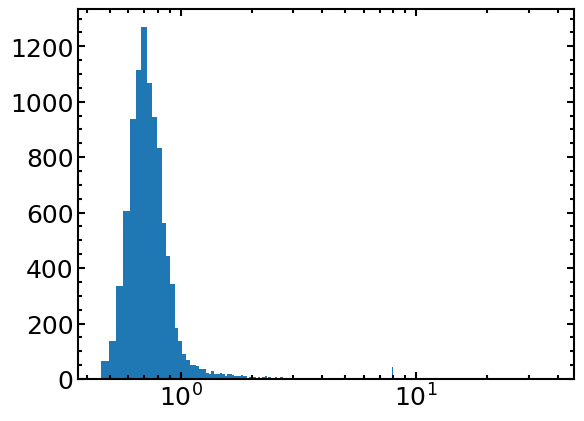

In [142]:
plt.hist(g_lst, bins=1000);
plt.xscale('log');

In [172]:
def get_k_mesh_by_density(cell, k_mesh_spacing=0.5):
    
    """
    Get k-mesh density according to the box size.
    Args:
        cell (numpy.ndarray/list): The cell shape
        k_mesh_spacing (float): K-point spacing in units of 2 * pi reciprocal Angstrom.
                                (smaller values result in a denser mesh for a given structure).
    Returns:
        list/numpy.ndarray: Mesh size
    """
    
    omega = np.linalg.det(cell)
    l1, l2, l3 = cell
    g1 = 2 * np.pi / omega * np.cross(l2, l3)
    g2 = 2 * np.pi / omega * np.cross(l3, l1)
    g3 = 2 * np.pi / omega * np.cross(l1, l2)

    kmesh = np.rint(
        np.array([np.linalg.norm(g) for g in [g1, g2, g3]]) / k_mesh_spacing
    )
    kmesh[kmesh < 1] = 1
    return [int(k) for k in kmesh]

In [181]:
init_path = '/home/users/saadie5f/piaggi/phase_diagram/full/notebooks/'
os.chdir('/home/users/saadie5f/piaggi/phase_diagram/upfit/test_data')

for i, atoms in enumerate(tqdm(df_all.sample(n=10000).ase_atoms)):
    atoms = deepcopy(atoms)
    os.mkdir(f'conf_pd_{i:03d}')
    os.chdir(f'conf_pd_{i:03d}')
    os.system('cp /home/users/saadie5f/vasp_files_water/INCAR .')
    os.system('cp /home/users/saadie5f/vasp_files_water/POTCAR .')
    os.system('cp /home/users/saadie5f/vasp_files_water/KPOINTS .')
    os.system('cp /home/users/saadie5f/vasp_files_water/sbatch.sh .')
    io.write('POSCAR', sort(atoms), format='vasp')
    kpoints = get_k_mesh_by_density((atoms.get_cell()), 0.125)
    lines = open('KPOINTS').readlines()
    lines[3] = f'{kpoints[0]} {kpoints[1]} {kpoints[2]}'
    with open("KPOINTS", "w") as outfile:
        outfile.writelines(lines)
    os.chdir('../')
os.chdir(init_path)

100%|██████████| 10000/10000 [06:39<00:00, 25.05it/s]


In [182]:
os.chdir(init_path)

In [664]:
os.chdir('/home/users/saadie5f/piaggi/phase_diagram/upfit/')

for i, atoms in enumerate(tqdm(pd.concat(df_lst+df_lst2).ase_atoms[::100])):
    os.mkdir(f'conf_init_{i:03d}')
    os.chdir(f'conf_init_{i:03d}')
    os.system('cp /home/users/saadie5f/vasp_files_water/INCAR .')
    os.system('cp /home/users/saadie5f/vasp_files_water/POTCAR .')
    os.system('cp /home/users/saadie5f/vasp_files_water/KPOINTS .')
    os.system('cp /home/users/saadie5f/vasp_files_water/sbatch.sh .')
    io.write('POSCAR', sort(atoms), format='vasp')
    kpoints = get_k_mesh_by_density((atoms.get_cell()), 0.125)
    lines = open('KPOINTS').readlines()
    lines[3] = f'{kpoints[0]} {kpoints[1]} {kpoints[2]}'
    with open("KPOINTS", "w") as outfile:
        outfile.writelines(lines)
    os.chdir('../')

100%|██████████| 104/104 [00:05<00:00, 18.80it/s]


In [58]:
df_i = pd.read_pickle('../../../../our_dft/ice_c_6_al_v3/data_ice_c_6_al_v3.gzip', compression='gzip')
df_f = pd.read_pickle('../../upfit/data.gzip', compression='gzip')

In [672]:
pd.to_pickle(pd.concat([df_i,df_f]),'../upfit/data_pd.gzip', compression='gzip')

In [683]:
from ase import units
def calc_rho(atoms):
    mol_mass_water = 18.015 
    mass = (mol_mass_water * len(atoms)/3) / units.mol * 1e24
    density = mass/atoms.get_volume()
    return density

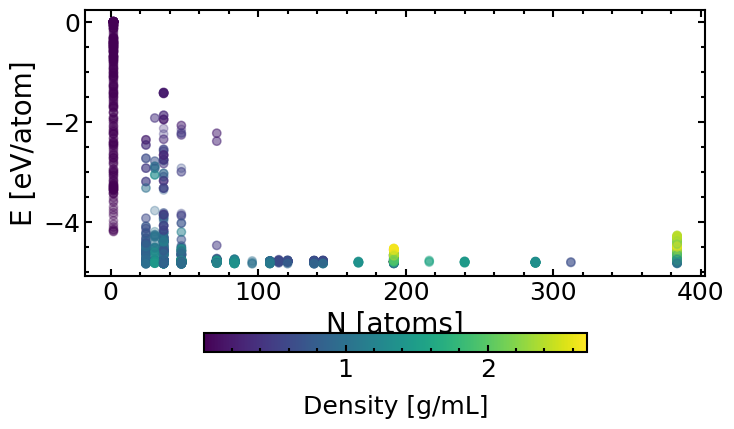

In [714]:
s=8
df = pd.concat([df_i,df_f])
fig, ax = plt.subplots(figsize=(s,s*0.618))
rho_lst = df.ase_atoms.map(calc_rho)
mappable = ax.scatter(df.ase_atoms.map(lambda atoms: len(atoms)), df.energy_corrected_per_atom,
                      alpha=0.3, c=rho_lst)
cbar = fig.colorbar(mappable=mappable, orientation='horizontal', shrink=0.618)
cbar.set_label(label='Density [g/mL]', fontsize=18, labelpad=10)
cbar.set_alpha(1)
cbar.draw_all()

ax.set_xlabel('N [atoms]', fontsize=20)
ax.set_ylabel('E [eV/atom]', fontsize=20);

In [35]:
g_lst = list()
for atoms in tqdm(pd.concat([df_]).ase_atoms[::10]):
    atoms.set_calculator(calc)
    atoms.get_potential_energy()
    g_lst.append(calc.results['gamma'].max())

  0%|          | 0/299 [00:00<?, ?it/s]/home/users/saadie5f/miniconda3/envs/ace/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|██████████| 299/299 [01:13<00:00,  4.05it/s]


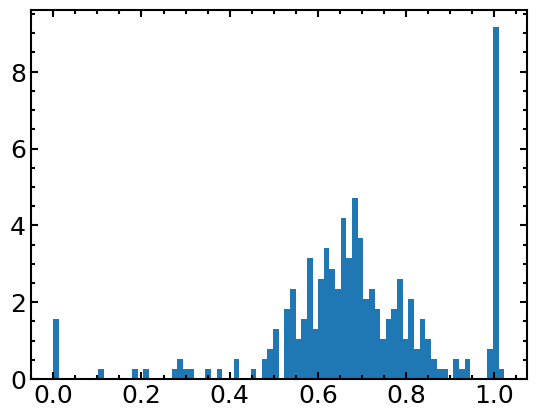

In [37]:
plt.hist(g_lst, bins=80, density=True);

In [48]:
df_fit = pd.read_pickle('/home/users/saadie5f/piaggi/phase_diagram/upfit/10000_ladder/\
fitting_data_info.pckl.gzip', compression='gzip')
df_fit

,energy,forces,ase_atoms,energy_corrected,energy_corrected_per_atom,name,NUMBER_OF_ATOMS,pbc,comp_dict,comp_tuple,n_H,c_H,n_O,c_O,e_formation_per_atom,e_chull_dist_per_atom,effective_energy,w_energy,w_forces
1693,-175.695841,"[[-0.22662113, 0.03523711, -0.38015245], [0.29...","(Atom('H', [5.4515905375703175, 1.061040967103...",-172.404693,-4.789019,data_pd.gzip:IX_shaken_44,36,True,"{'H': 24, 'O': 12}","((H, 0.6666666666666666), (O, 0.33333333333333...",24,0.666667,12,0.333333,-1.149018,0.053107,0.053107,0.000300,"[4.2247690298910236e-06, 4.13732459438298e-06,..."
134,-234.336883,"[[-0.86027756, -1.34268975, 1.24048577], [-1.3...","(Atom('H', [2.3765041759952874, 2.485202205385...",-229.948685,-4.790598,data_pd.gzip:engel03_shaken_2,48,True,"{'H': 32, 'O': 16}","((H, 0.6666666666666666), (O, 0.33333333333333...",32,0.666667,16,0.333333,-1.150596,0.051528,0.051528,0.000301,"[3.5539226546282983e-06, 3.9229733232936675e-0..."
411,-413.320767,"[[-0.0740745, -0.06996668, -0.09572235], [-0.0...","(Atom('H', [6.55167965067082, 1.43851670976563...",-405.641421,-4.829065,data_pd.gzip:ice5_shaken_0,84,True,"{'H': 56, 'O': 28}","((H, 0.6666666666666666), (O, 0.33333333333333...",56,0.666667,28,0.333333,-1.189063,0.013062,0.013062,0.000325,"[4.605865965082039e-06, 4.60314480451284e-06, ..."
203,-943.382753,"[[-0.047856, -0.08507882, -0.12072308], [-0.79...","(Atom('H', [3.957412471902161, 9.0006613875885...",-925.829962,-4.822031,data_pd.gzip:SGT_shaken_0,192,True,"{'H': 128, 'O': 64}","((H, 0.6666666666666666), (O, 0.33333333333333...",128,0.666667,64,0.333333,-1.182029,0.020095,0.020095,0.000320,"[4.5415367886166075e-06, 4.298409531954779e-06..."
2275,-1.72279,"[[1.74647715, 1.74647396, 1.74650097], [-1.746...","(Atom('O', [0.0, 0.0, 0.0], index=0), Atom('O'...",-1.674291,-0.837145,data_pd.gzip:oo_115,2,True,{'O': 2},"((O, 1.0),)",0,0.000000,2,1.000000,3.360685,3.360685,3.360685,0.000509,"[4.960599306425625e-06, 4.960599306425625e-06]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,-3.681248,"[[2.19038667, 2.19038667, 2.19038821], [-2.190...","(Atom('H', [0.0, 0.0, 0.0], index=0), Atom('H'...",-3.431235,-1.715618,data_pd.gzip:hh_65,2,True,{'H': 2},"((H, 1.0),)",2,1.000000,0,0.000000,1.64547,1.645470,1.645470,0.001383,"[1.1423807604570303e-05, 1.1423807604570303e-05]"
1653,-175.379567,"[[0.38632228, 0.46214042, 0.39105558], [-4.261...","(Atom('H', [-0.20746927438008483, -3.560200741...",-172.088419,-4.780234,data_pd.gzip:II_shaken_49,36,True,"{'H': 24, 'O': 12}","((H, 0.6666666666666666), (O, 0.33333333333333...",24,0.666667,12,0.333333,-1.140232,0.061892,0.061892,0.000295,"[4.090618914328854e-06, 1.9206912631877426e-06..."
160,-177.274345,"[[-0.16033734, -0.36445584, -0.43346814], [0.2...","(Atom('H', [-0.25358255174876393, -3.190324997...",-173.983197,-4.832867,data_pd.gzip:2_shaken_0,36,True,"{'H': 24, 'O': 12}","((H, 0.6666666666666666), (O, 0.33333333333333...",24,0.666667,12,0.333333,-1.192865,0.009260,0.009260,0.000327,"[4.566077021976959e-06, 4.616319546804681e-06,..."
1754,-528.743593,"[[-2.62730478, 1.2944482, -0.99516176], [-0.69...","(Atom('H', [8.961972796485748, 8.5402224885203...",-518.870148,-4.804353,data_pd.gzip:PCOD8321499_shaken_31,108,True,"{'H': 72, 'O': 36}","((H, 0.6666666666666666), (O, 0.33333333333333...",72,0.666667,36,0.333333,-1.164351,0.037773,0.037773,0.000309,"[2.9716708499558118e-06, 3.7503951052280162e-0..."


In [49]:
df_v = validate(calc, df_fit[::1])

100%|██████████| 2949/2949 [03:20<00:00, 14.70it/s]


Text(0, 0.5, 'F$\\mathrm{^{ACE}}$ $\\mathrm{[eV/\\AA]}$')

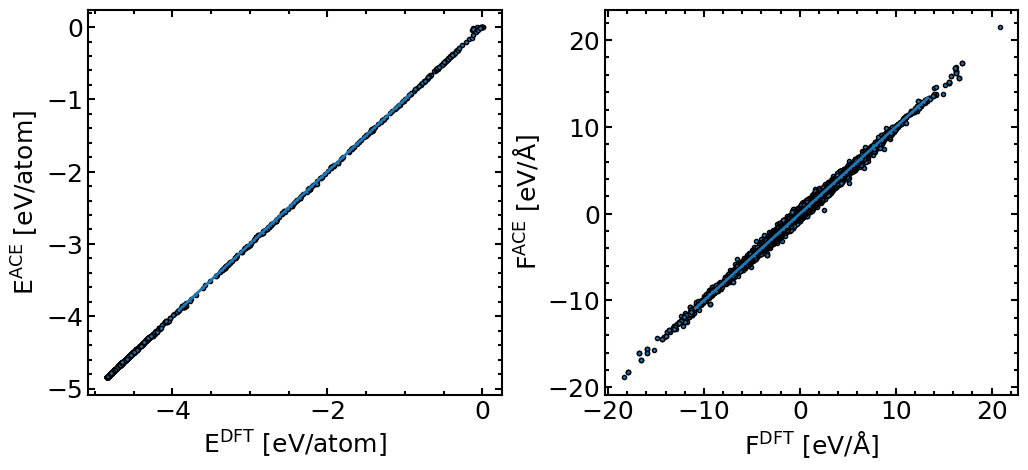

In [78]:
fig, ax = plt.subplots(figsize=(12,5), ncols=2, sharey=False)
fig.subplots_adjust(wspace=.25)

df_t = df_fit
n = 1

ax[0].scatter(df_t[::n].energy_corrected_per_atom, df_v.energy, marker='.', color='C0', edgecolor='k')
ax[1].scatter(np.vstack(df_t[::n].forces.values).flatten(),
              np.vstack(df_v.forces.values).flatten(), marker='.', color='C0', edgecolor='k')


e_min = df_t[::n].energy_corrected_per_atom.min() 
e_max = df_t[::n].energy_corrected_per_atom.max()

f = 0.618

l = e_max - e_min
m = e_min + l*0.5
x1 = m-l*f*0.5
x2 = m+l*f*0.5
ax[0].plot([x1, x2], [x1,x2], c='C0', lw=2, ls='-')

f_min = np.vstack(df_t[::n].forces.values).flatten().min()
f_max = np.vstack(df_t[::n].forces.values).flatten().max()


l = f_max - f_min
m = f_min + l*0.5

x1 = m-l*f*0.5
x2 = m+l*f*0.5

ax[1].plot([x1, x2], [x1,x2], c='C0', lw=2, ls='-')


ax[0].set_xlabel('E$\mathrm{^{DFT}}$ [eV/atom]')
ax[1].set_xlabel('F$\mathrm{^{DFT}}$ $\mathrm{[eV/\AA]}$')

ax[0].set_ylabel('E$\mathrm{^{ACE}}$ [eV/atom]')
ax[1].set_ylabel('F$\mathrm{^{ACE}}$ $\mathrm{[eV/\AA]}$')
# ax[1].set_ylabel(r'$\mathrm{F^{ACE}}$', rotation=90, labelpad=-5)

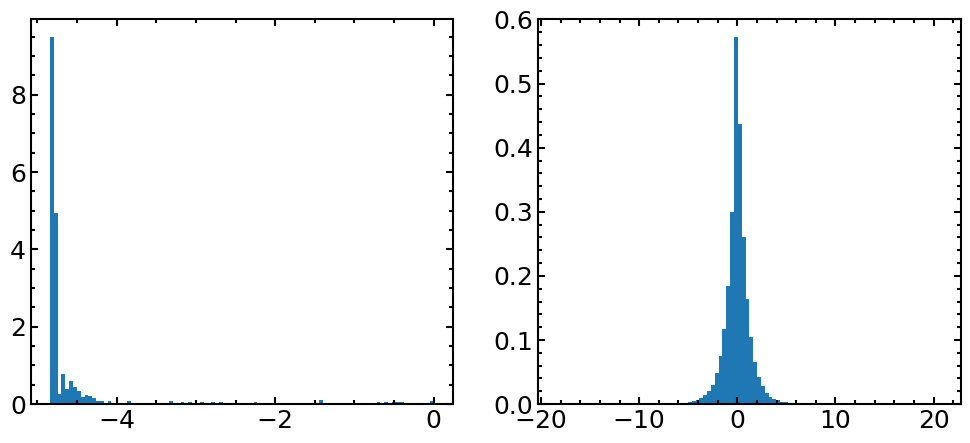

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].hist(np.vstack(df_fit[::1].energy_corrected_per_atom.values), bins=100, density=True);
ax[1].hist(np.vstack(df_fit[::1].forces.values).flatten(), bins=100, density=True);

In [20]:
ld_met_200 = read_metrics('../../upfit/200_ladder/metrics.txt')
ld_met_2000 = read_metrics('../../upfit/2000_ladder/metrics.txt')
ld_met_10000 = read_metrics('../../upfit/10000_ladder/metrics.txt')
ld_met_10000_00 = read_metrics('../../upfit/10000_ladder/metrics.txt')
ld_met_10000_01 = read_metrics('../../upfit/10000_ladder/cont_01/metrics.txt')
ld_met_10000_02 = read_metrics('../../upfit/10000_ladder/cont_02/metrics.txt')
ld_met_10000 = pd.concat([ld_met_10000_00, ld_met_10000_01, ld_met_10000_02])

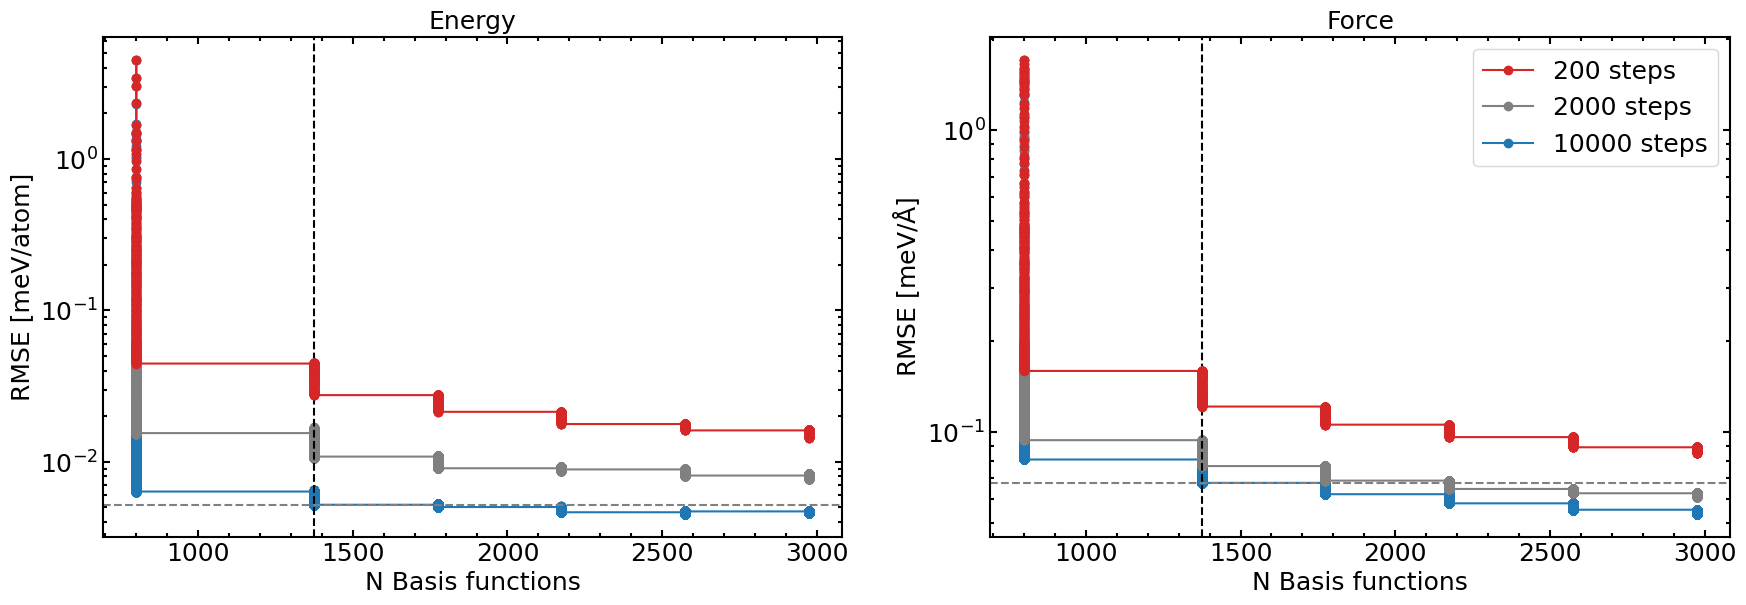

In [88]:
s = 21
fig, axs = plt.subplots(figsize=(s,s*0.618*0.5), ncols=2)

args_200 = ld_met_200.nfuncs < 3000
args_2000 = ld_met_2000.nfuncs < 3000

axs[0].plot(ld_met_200.nfuncs[args_200], ld_met_200.rmse_epa[args_200],'-o', zorder=3,  c='C3')
axs[0].plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_epa[args_2000],'-o', zorder=2, c='gray')
axs[0].plot(ld_met_10000.nfuncs, ld_met_10000.rmse_epa,'-o', zorder=1, c='C0')



# axs[0].axvspan(0,ld_met.nfuncs[5], alpha=0.2, color='k')
axs[1].plot(ld_met_200.nfuncs[args_200], ld_met_200.rmse_f_comp[args],
            '-o', zorder=3, c='C3', label='200 steps')
axs[1].plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_f_comp[args_2000],
            '-o', zorder=2, c='gray', label='2000 steps')
axs[1].plot(ld_met_10000.nfuncs, ld_met_10000.rmse_f_comp, '-o', zorder=1, c='C0', label='10000 steps')
# axs[1].scatter(ld_met_f.nfuncs, ld_met.rmse_f_comp, marker='o',  c='k')
# axs[1].axvspan(0,ld_met.nfuncs[5], alpha=0.2, color='k')

axs[0].axvline(np.unique(ld_met_10000_00.nfuncs)[1], color='k', ls='--')
axs[0].axhline(ld_met_10000_00.rmse_epa[ld_met_10000_00.nfuncs == np.unique(ld_met_10000_00.nfuncs)[1]].min()
               , color='gray', ls='--')

axs[1].axvline(np.unique(ld_met_10000_00.nfuncs)[1], color='k', ls='--')
axs[1].axhline(ld_met_10000_00.rmse_f_comp[ld_met_10000_00.nfuncs == np.unique(ld_met_10000_00.nfuncs)[1]].min()
               , color='gray', ls='--')

axs[0].set_xlabel('N Basis functions', fontsize=18)
axs[1].set_xlabel('N Basis functions', fontsize=18)

axs[0].set_ylabel('RMSE [meV/atom]', fontsize=18)
axs[1].set_ylabel(r'RMSE [meV/$\mathrm{\AA}$]', fontsize=18)

axs[0].set_title('Energy', fontsize=18)
axs[1].set_title('Force', fontsize=18)

axs[1].legend()

# axs[0].set_xscale('log')
# axs[1].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log');

In [30]:
np.unique(ld_met_10000_00.nfuncs)[1],np.unique(ld_met_10000_00.nfuncs)[2]

(1374, 1774)

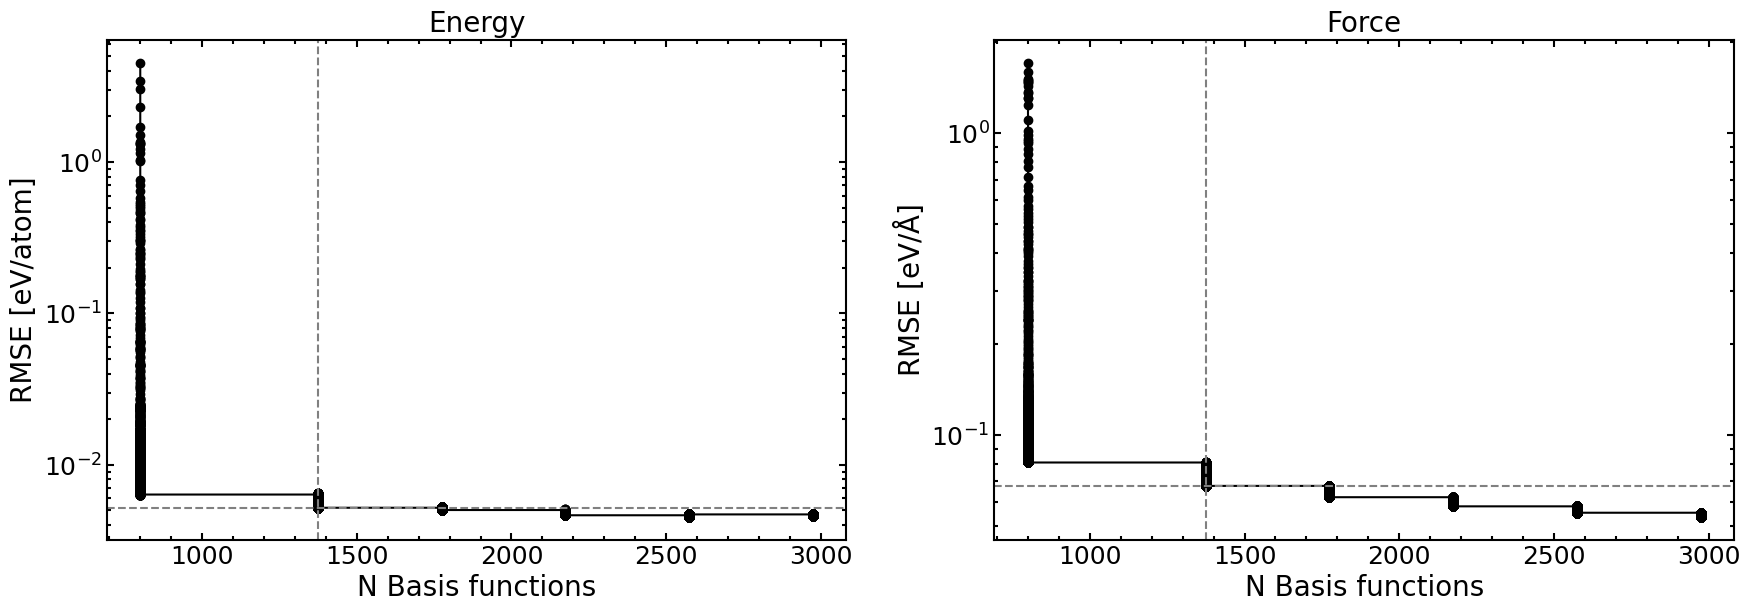

In [24]:
s = 21
fig, axs = plt.subplots(figsize=(s,s*0.618*0.5), ncols=2)

# axs[0].plot(ld_met_200.nfuncs, ld_met_200.rmse_epa, '-o', zorder=1, c='C3')
# axs[0].plot(ld_met_2000.nfuncs, ld_met_2000.rmse_epa, '-o', zorder=1, c='gray')
# axs[0].plot(ld_met_10000.nfuncs, ld_met_10000.rmse_epa, '-o', zorder=1, c='C0')
axs[0].plot(ld_met_10000.nfuncs, ld_met_10000.rmse_epa, '-o', zorder=1, c='k')

# axs[0].axvspan(0,ld_met.nfuncs[5], alpha=0.2, color='k')

# axs[1].plot(ld_met_200.nfuncs, ld_met_200.rmse_f_comp, '-o', zorder=1, c='C3', label='200_ladder')
# axs[1].plot(ld_met_2000.nfuncs, ld_met_2000.rmse_f_comp, '-o', zorder=1, c='gray', label='2000_ladder')
# axs[1].plot(ld_met_10000.nfuncs, ld_met_10000.rmse_f_comp, '-o', zorder=1, c='C0', label='10000_ladder')
axs[1].plot(ld_met_10000.nfuncs, ld_met_10000.rmse_f_comp, '-o', zorder=1, c='k')

# axs[1].scatter(ld_met_f.nfuncs, ld_met.rmse_f_comp, marker='o',  c='k')
# axs[1].axvspan(0,ld_met.nfuncs[5], alpha=0.2, color='k')

axs[0].axvline(np.unique(ld_met_10000_00.nfuncs)[1], color='gray', ls='--')
axs[0].axhline(ld_met_10000_00.rmse_epa[ld_met_10000_00.nfuncs == np.unique(ld_met_10000_00.nfuncs)[1]].min()
               , color='gray', ls='--')

axs[1].axvline(np.unique(ld_met_10000_00.nfuncs)[1], color='gray', ls='--')
axs[1].axhline(ld_met_10000_00.rmse_f_comp[ld_met_10000_00.nfuncs == np.unique(ld_met_10000_00.nfuncs)[1]].min()
               , color='gray', ls='--')

fs = 20
axs[0].set_xlabel('N Basis functions', fontsize=fs)
axs[1].set_xlabel('N Basis functions', fontsize=fs)

axs[0].set_ylabel('RMSE [eV/atom]', fontsize=fs)
axs[1].set_ylabel(r'RMSE [eV/$\mathrm{\AA}$]', fontsize=fs)

axs[0].set_title('Energy', fontsize=fs)
axs[1].set_title('Force', fontsize=fs)

# axs[1].legend()

# axs[0].set_xscale('log')
# axs[1].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log');

In [ ]:
np.round(2.380144,1)

In [134]:
get_metrics(df_v.energy, np.vstack(df_v.forces.values), df_fit)*1e3

,rmse_epa,rmse_f_comp,mae_epa,mae_f_comp
0,5.1991,67.661647,2.380144,35.320937


In [135]:
from scipy import stats

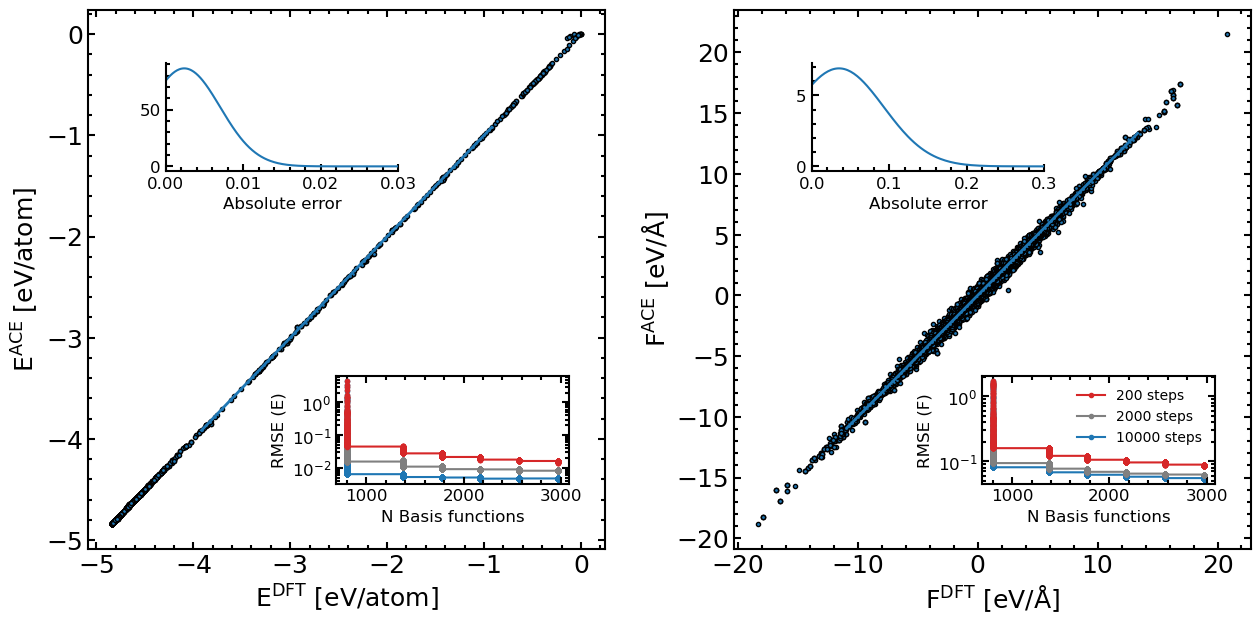

In [215]:
fig, ax = plt.subplots(figsize=(15,7), ncols=2, sharey=False)
fig.subplots_adjust(wspace=.25)
ax = ax.flatten()

n=1
ax[0].scatter(df_t[::n].energy_corrected_per_atom, df_v.energy, marker='.', color='C0', edgecolor='k')
ax[1].scatter(np.vstack(df_t[::n].forces.values).flatten(),
              np.vstack(df_v.forces.values).flatten(), marker='.', color='C0', edgecolor='k')


e_min = df_t[::n].energy_corrected_per_atom.min() 
e_max = df_t[::n].energy_corrected_per_atom.max()

f = 0.618

l = e_max - e_min
m = e_min + l*0.5
x1 = m-l*f*0.5
x2 = m+l*f*0.5
ax[0].plot([x1, x2], [x1,x2], c='C0', lw=2, ls='-')

f_min = np.vstack(df_t[::n].forces.values).flatten().min()
f_max = np.vstack(df_t[::n].forces.values).flatten().max()


l = f_max - f_min
m = f_min + l*0.5

x1 = m-l*f*0.5
x2 = m+l*f*0.5

ax[1].plot([x1, x2], [x1,x2], c='C0', lw=2, ls='-')



axinse = ax[0].inset_axes([0.15,0.7,0.45,0.2])

dE = np.array(np.abs(df_t.energy_corrected_per_atom.values-df_v.energy.values),dtype=float)
mu = np.mean(dE)
std = np.std(dE)
hist_res = np.histogram(dE, bins=1000, density=True);
dExx = hist_res[1]
axinse.plot(dExx, stats.norm.pdf(dExx, loc=mu, scale=std), color='C0', ls='-')
axinse.set_xlim(0,0.03)
axinse.set_xlabel('Absolute error', fontsize=12)
axinse.spines.right.set_visible(False)
axinse.spines.top.set_visible(False)
axinse.tick_params(axis='both', which='both', top=False, right=False, labelsize=12)



axinsf = ax[1].inset_axes([0.15,0.7,0.45,0.2])
dF = np.abs(np.vstack(df_t[::n].forces.values).flatten()-np.vstack(df_v.forces.values).flatten())
mu = np.mean(dF)
std = np.std(dF)
hist_res = np.histogram(dF, bins=1000, density=True);
dFxx = hist_res[1]
axinsf.plot(dFxx, stats.norm.pdf(dFxx, loc=mu, scale=std), color='C0', ls='-')
axinsf.set_xlim(0,0.3)
axinsf.set_xlabel('Absolute error', fontsize=12)
axinsf.spines.right.set_visible(False)
axinsf.spines.top.set_visible(False)
axinsf.tick_params(axis='both', which='both', top=False, right=False, labelsize=12)

axinste = ax[0].inset_axes([0.48,0.12,0.45,0.2])
axinste.plot(ld_met_200.nfuncs[args_200], ld_met_200.rmse_epa[args_200],'-',marker='.', zorder=3,  c='C3')
axinste.plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_epa[args_2000],'-',marker='.', zorder=2, c='gray')
axinste.plot(ld_met_10000.nfuncs, ld_met_10000.rmse_epa,'-',marker='.', zorder=1, c='C0')
axinste.set_xlabel('N Basis functions', fontsize=12)
axinste.set_ylabel('RMSE (E)', fontsize=12)
axinste.tick_params(axis="both", labelsize=12)


axinstf = ax[1].inset_axes([0.48,0.12,0.45,0.2])
axinstf.plot(ld_met_200.nfuncs[args_200], ld_met_200.rmse_f_comp[args],
            '-', marker='.', zorder=3, c='C3', label='200 steps')
axinstf.plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_f_comp[args_2000],
            '-', marker='.', zorder=2, c='gray', label='2000 steps')
axinstf.plot(ld_met_10000.nfuncs, ld_met_10000.rmse_f_comp, '-',
             marker='.', zorder=1, c='C0', label='10000 steps')
axinstf.tick_params(axis="both", labelsize=12)
axinste.set_yscale('log')
axinstf.set_yscale('log')
axinstf.legend(fontsize=10, frameon=0)
axinstf.set_xlabel('N Basis functions', fontsize=12)
axinstf.set_ylabel('RMSE (F)', fontsize=12)

# axinstf.set_xlabel('GPU time $\mathrm{[\mu s/atom]}$', fontsize=12)
# axinstf.set_ylabel('RMSE (F)', fontsize=12)



# axinse.set_xscale('log')
# axins.set_yscale('log')
# axs[1].set_xscale('log')
# axs[1].set_yscale('log');

ax[0].set_xlabel('E$\mathrm{^{DFT}}$ [eV/atom]')
ax[1].set_xlabel('F$\mathrm{^{DFT}}$ $\mathrm{[eV/\AA]}$')

ax[0].set_ylabel('E$\mathrm{^{ACE}}$ [eV/atom]')
ax[1].set_ylabel('F$\mathrm{^{ACE}}$ $\mathrm{[eV/\AA]}$')
fig.savefig('../figures/train_all.png', bbox_inches = 'tight', dpi=300);

Text(0, 0.5, 'F$\\mathrm{^{ACE}}$ $\\mathrm{[eV/\\AA]}$')

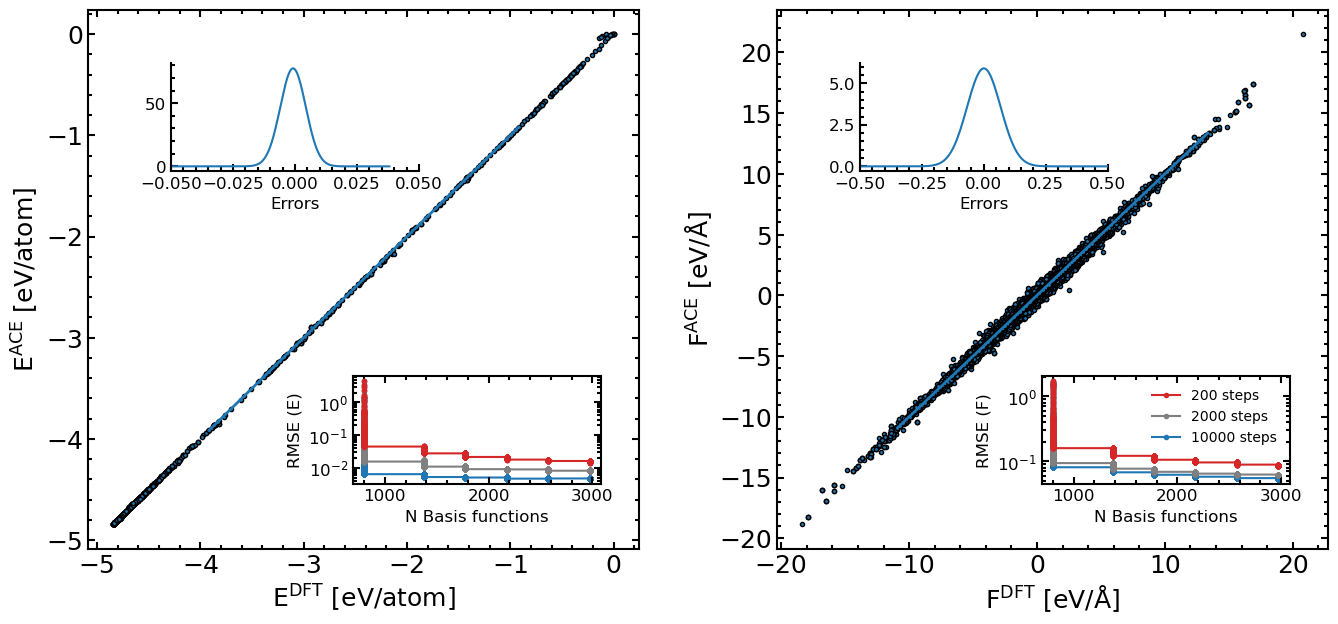

In [274]:
fig, ax = plt.subplots(figsize=(16,7), ncols=2, sharey=False)
fig.subplots_adjust(wspace=.25)
ax = ax.flatten()

n=1
ax[0].scatter(df_t[::n].energy_corrected_per_atom, df_v.energy, marker='.', color='C0', edgecolor='k')
ax[1].scatter(np.vstack(df_t[::n].forces.values).flatten(),
              np.vstack(df_v.forces.values).flatten(), marker='.', color='C0', edgecolor='k')


e_min = df_t[::n].energy_corrected_per_atom.min() 
e_max = df_t[::n].energy_corrected_per_atom.max()

f = 0.618

l = e_max - e_min
m = e_min + l*0.5
x1 = m-l*f*0.5
x2 = m+l*f*0.5
ax[0].plot([x1, x2], [x1,x2], c='C0', lw=2, ls='-')

f_min = np.vstack(df_t[::n].forces.values).flatten().min()
f_max = np.vstack(df_t[::n].forces.values).flatten().max()


l = f_max - f_min
m = f_min + l*0.5

x1 = m-l*f*0.5
x2 = m+l*f*0.5

ax[1].plot([x1, x2], [x1,x2], c='C0', lw=2, ls='-')



axinse = ax[0].inset_axes([0.15,0.7,0.45,0.2])

dE = np.array(df_t.energy_corrected_per_atom.values-df_v.energy.values,dtype=float)
mu = np.mean(dE)
std = np.std(dE)
hist_res = np.histogram(dE, bins=1000, density=True);
dExx = hist_res[1]
axinse.plot(dExx, stats.norm.pdf(dExx, loc=mu, scale=std), color='C0', ls='-')
axinse.set_xlim(-0.05,0.05)
axinse.set_xlabel('Errors', fontsize=12)
axinse.spines.right.set_visible(False)
axinse.spines.top.set_visible(False)
axinse.tick_params(axis='both', which='both', top=False, right=False, labelsize=12)



axinsf = ax[1].inset_axes([0.15,0.7,0.45,0.2])
dF = np.vstack(df_t[::n].forces.values).flatten()-np.vstack(df_v.forces.values).flatten()
mu = np.mean(dF)
std = np.std(dF)
hist_res = np.histogram(dF, bins=1000, density=True);
dFxx = hist_res[1]
axinsf.plot(dFxx, stats.norm.pdf(dFxx, loc=mu, scale=std), color='C0', ls='-')
axinsf.set_xlim(-0.5,0.5)
axinsf.set_xlabel('Errors', fontsize=12)
axinsf.spines.right.set_visible(False)
axinsf.spines.top.set_visible(False)
axinsf.tick_params(axis='both', which='both', top=False, right=False, labelsize=12)

axinste = ax[0].inset_axes([0.48,0.12,0.45,0.2])
axinste.plot(ld_met_200.nfuncs[args_200], ld_met_200.rmse_epa[args_200],'-',marker='.', zorder=3,  c='C3')
axinste.plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_epa[args_2000],'-',marker='.', zorder=2, c='gray')
axinste.plot(ld_met_10000.nfuncs, ld_met_10000.rmse_epa,'-',marker='.', zorder=1, c='C0')
axinste.set_xlabel('N Basis functions', fontsize=12)
axinste.set_ylabel('RMSE (E)', fontsize=12)
axinste.tick_params(axis="both", labelsize=12)


axinstf = ax[1].inset_axes([0.48,0.12,0.45,0.2])
axinstf.plot(ld_met_200.nfuncs[args_200], ld_met_200.rmse_f_comp[args],
            '-', marker='.', zorder=3, c='C3', label='200 steps')
axinstf.plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_f_comp[args_2000],
            '-', marker='.', zorder=2, c='gray', label='2000 steps')
axinstf.plot(ld_met_10000.nfuncs, ld_met_10000.rmse_f_comp, '-',
             marker='.', zorder=1, c='C0', label='10000 steps')
axinstf.tick_params(axis="both", labelsize=12)
axinste.set_yscale('log')
axinstf.set_yscale('log')
axinstf.legend(fontsize=10, frameon=0)
axinstf.set_xlabel('N Basis functions', fontsize=12)
axinstf.set_ylabel('RMSE (F)', fontsize=12)

# axinstf.set_xlabel('GPU time $\mathrm{[\mu s/atom]}$', fontsize=12)
# axinstf.set_ylabel('RMSE (F)', fontsize=12)



# axinse.set_xscale('log')
# axins.set_yscale('log')
# axs[1].set_xscale('log')
# axs[1].set_yscale('log');

ax[0].set_xlabel('E$\mathrm{^{DFT}}$ [eV/atom]')
ax[1].set_xlabel('F$\mathrm{^{DFT}}$ $\mathrm{[eV/\AA]}$')

ax[0].set_ylabel('E$\mathrm{^{ACE}}$ [eV/atom]')
ax[1].set_ylabel('F$\mathrm{^{ACE}}$ $\mathrm{[eV/\AA]}$')
#fig.savefig('../figures/train_all_pd.png', bbox_inches = 'tight', dpi=400);

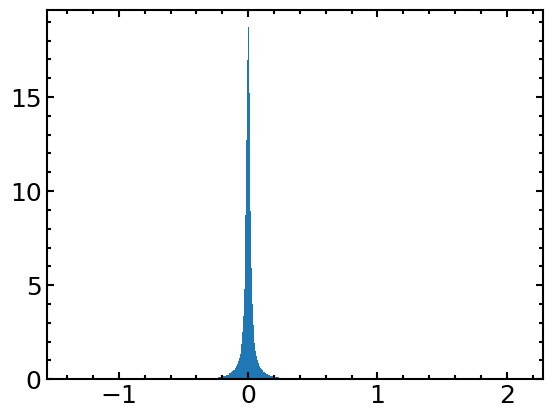

In [335]:
plt.hist(dF, density=True, bins=1000);

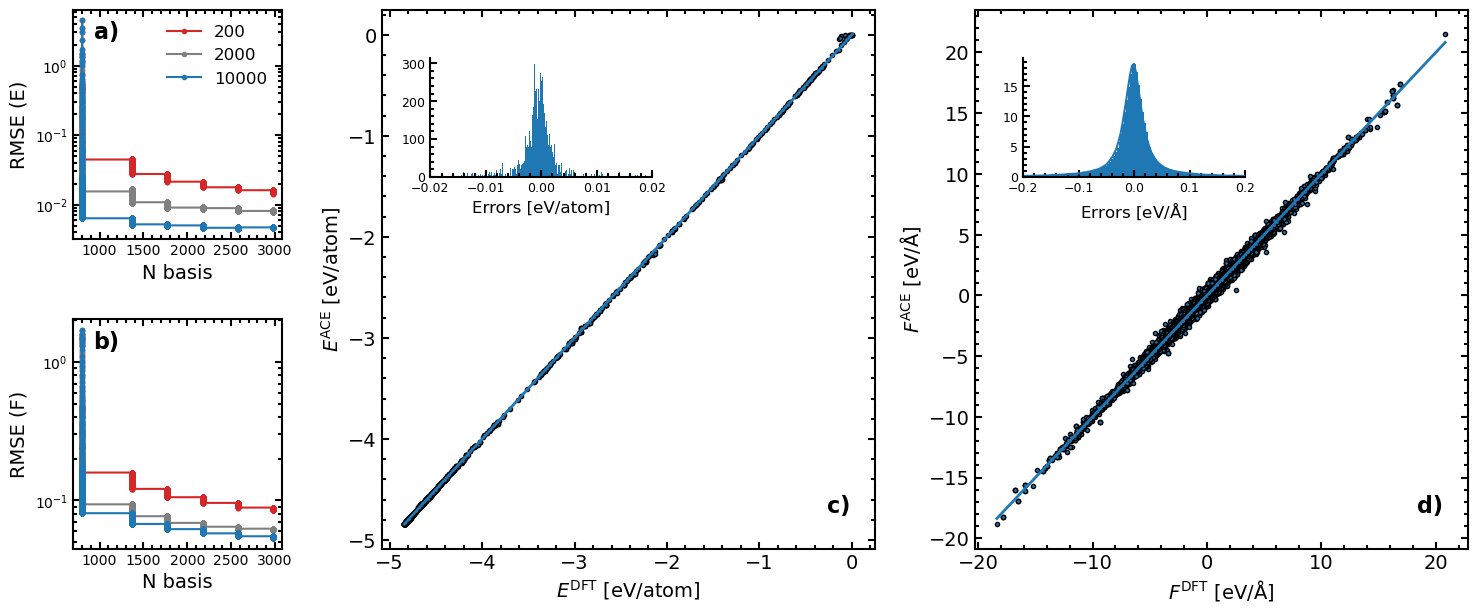

In [348]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mpl.rcParams['font.size'] = 14
# --- Figure layout: [ RMSE column | Energy parity | Force parity ] ---
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(
    nrows=1, ncols=3,
    width_ratios=[1.7, 4.0, 4.0],
    wspace=0.25
)

# Left column split into two stacked panels (A,B)
gs_left = gs[0, 0].subgridspec(nrows=2, ncols=1, hspace=0.35)
ax_rmse_E = fig.add_subplot(gs_left[0, 0])  # A
ax_rmse_F = fig.add_subplot(gs_left[1, 0])  # B

# Main parity plots
ax_E = fig.add_subplot(gs[0, 1])
ax_F = fig.add_subplot(gs[0, 2])

# -------------------------
# 1) Parity plots (same as before, just replace ax[0]/ax[1] by ax_E/ax_F)
# -------------------------

n = 1
ax_E.scatter(df_t[::n].energy_corrected_per_atom, df_v.energy, marker='.', color='C0', edgecolor='k')
ax_F.scatter(np.vstack(df_t[::n].forces.values).flatten(),
             np.vstack(df_v.forces.values).flatten(),
             marker='.', color='C0', edgecolor='k')

# Diagonal lines (keep your golden-ratio trimming if you like; here is simple version)
e_min, e_max = df_t[::n].energy_corrected_per_atom.min(), df_t[::n].energy_corrected_per_atom.max()
ax_E.plot([e_min, e_max], [e_min, e_max], c='C0', lw=2)

f_min = np.vstack(df_t[::n].forces.values).flatten().min()
f_max = np.vstack(df_t[::n].forces.values).flatten().max()
ax_F.plot([f_min, f_max], [f_min, f_max], c='C0', lw=2)

ax_E.set_xlabel(r'$E^{\mathrm{DFT}}$ [eV/atom]')
ax_E.set_ylabel(r'$E^{\mathrm{ACE}}$ [eV/atom]')
ax_F.set_xlabel(r'$F^{\mathrm{DFT}}$ [eV/$\mathrm{\AA}$]')
ax_F.set_ylabel(r'$F^{\mathrm{ACE}}$ [eV/$\mathrm{\AA}$]')

# -------------------------
# 2) Top insets INSIDE parity plots (C, D)  <-- keep them as in your screenshot
# -------------------------

ax_E_pdf = inset_axes(ax_E, width="45%", height="22%", loc="upper left", borderpad=2.5)
dE = np.array(df_t.energy_corrected_per_atom.values - df_v.energy.values, dtype=float)
muE, stdE = np.mean(dE), np.std(dE)
histE = np.histogram(dE, bins=1000, density=True)
xE = histE[1]
#ax_E_pdf.plot(xE, stats.norm.pdf(xE, loc=muE, scale=stdE), color='C0')
ax_E_pdf.hist(dE, density=True, bins=1000)
ax_E_pdf.set_xlim(-0.02, 0.02)
ax_E_pdf.set_xlabel('Errors [eV/atom]', fontsize=12)
ax_E_pdf.spines[['top', 'right']].set_visible(False)
ax_E_pdf.tick_params(axis='both', which='both', top=False, right=False, labelsize=9)

ax_F_pdf = inset_axes(ax_F, width="45%", height="22%", loc="upper left", borderpad=2.5)
dF = np.vstack(df_t[::n].forces.values).flatten() - np.vstack(df_v.forces.values).flatten()
muF, stdF = np.mean(dF), np.std(dF)
histF = np.histogram(dF, bins=1000, density=True)
xF = histF[1]
#ax_F_pdf.plot(xF, stats.norm.pdf(xF, loc=muF, scale=stdF), color='C0')
ax_F_pdf.hist(dF, density=True, bins=1000)
ax_F_pdf.plot(histF[1][:-1],histF[0], color='C0')
ax_F_pdf.set_xlim(-0.2, 0.2)
ax_F_pdf.set_xlabel('Errors [eV/$\mathrm{\AA}$]', fontsize=12)
ax_F_pdf.spines[['top', 'right']].set_visible(False)
ax_F_pdf.tick_params(axis='both', which='both', top=False, right=False, labelsize=9)

# -------------------------
# 3) RMSE panels OUTSIDE on the left (A, B)
# -------------------------

ax_rmse_E.plot(ld_met_200.nfuncs[args_200],   ld_met_200.rmse_epa[args_200],   '-', marker='.', c='C3'
               ,label='200')
ax_rmse_E.plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_epa[args_2000], '-', marker='.', c='gray'
               ,label='2000')
ax_rmse_E.plot(ld_met_10000.nfuncs,           ld_met_10000.rmse_epa,           '-', marker='.', c='C0'
               ,label='10000')
ax_rmse_E.set_yscale('log')
ax_rmse_E.set_xlabel('N basis')
ax_rmse_E.set_ylabel('RMSE (E)')
ax_rmse_E.legend(frameon=False, fontsize=12)
# ax_rmse_E.spines[['top', 'right']].set_visible(False)

ax_rmse_F.plot(ld_met_200.nfuncs[args_200],   ld_met_200.rmse_f_comp[args_200],   '-', marker='.', c='C3'
               ,label='200')
ax_rmse_F.plot(ld_met_2000.nfuncs[args_2000], ld_met_2000.rmse_f_comp[args_2000], '-', marker='.', c='gray'
               ,label='2000')
ax_rmse_F.plot(ld_met_10000.nfuncs,           ld_met_10000.rmse_f_comp,           '-', marker='.', c='C0'
               ,label='10000')
ax_rmse_F.set_yscale('log')
ax_rmse_F.set_xlabel('N basis')
ax_rmse_F.set_ylabel('RMSE (F)')
#ax_rmse_F.legend(frameon=False, fontsize=9)
# ax_rmse_F.spines[['top', 'right']].set_visible(False)

# Optional: tidy ticks on the left column so it looks like a “side panel”
for ax in (ax_rmse_E, ax_rmse_F):
    ax.tick_params(labelsize=10)


label_kwargs = dict(fontsize=16, fontweight='bold', va='top')

ax_rmse_E.text(0.1, 0.95, 'a)', transform=ax_rmse_E.transAxes, ha='left',  **label_kwargs)
ax_rmse_F.text(0.1, 0.95, 'b)', transform=ax_rmse_F.transAxes, ha='left',  **label_kwargs)

ax_E.text(0.95, 0.1, 'c)', transform=ax_E.transAxes, ha='right', **label_kwargs)
ax_F.text(0.95, 0.1, 'd)', transform=ax_F.transAxes, ha='right', **label_kwargs)
    
mpl.rcParams['font.size'] = 18
fig.savefig('../figures/train_all_pd.png', bbox_inches = 'tight', dpi=400);

In [249]:
dE = np.array(np.abs(df_t.energy_corrected_per_atom.values-df_v.energy.values),dtype=float)
mu = np.mean(dE)
std = np.std(dE)
hist_res = np.histogram(dE, bins=1000, density=True);
dExx = hist_res[1]
x = dExx
y = stats.norm.pdf(dExx, loc=mu, scale=std)

In [250]:
mu*1e3, std*1e3

(2.380143938611833, 4.622289425304081)

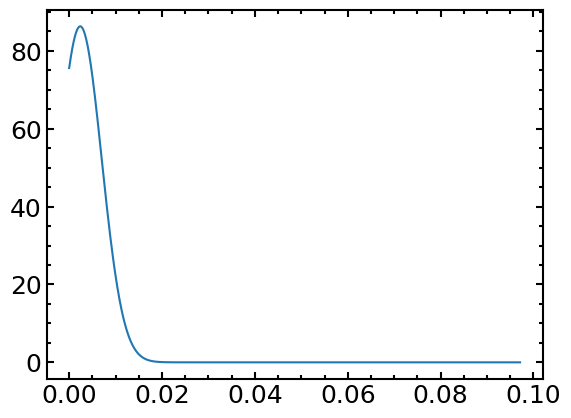

In [241]:
plt.plot(x, y)

In [244]:
x[np.argmax(y)]*1e3

2.428188982294961

In [245]:
dF = np.abs(np.vstack(df_t[::n].forces.values).flatten()-np.vstack(df_v.forces.values).flatten())
mu = np.mean(dF)
std = np.std(dF)
hist_res = np.histogram(dF, bins=1000, density=True);
dFxx = hist_res[1]
x = dFxx
y = stats.norm.pdf(dFxx, loc=mu, scale=std)

In [247]:
mu*1e3, std*1e3

(35.320936899271125, 57.710743821724726)

In [248]:
x[np.argmax(y)]*1e3

35.757509511766905